In [1]:
import jax
# NUTS sampling was faster with cpu in this case
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import jax.random as jr

import arviz as az
import arviz.labels as azl

import einops
import os

key = jr.PRNGKey(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow_probability.substrates.jax as tfp

2024-01-12 14:12:26.569164: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 14:12:26.950449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-12 14:12:26.950511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-12 14:12:26.950516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [3]:
from preprocessing import load_data,generate_indices,generate_XY,generate_indices_cumulative
from models import gen_model,sigmoid,run_nuts,mean_predictions,gen_predictive,diagnostics,increase_in_heterogeneity
from plots import prior_predictive,plot_posterior,posterior_comparisons,\
    plot_mean,plot_heterogeneity,compare_heterogeneity,compare_micromacro

Normalize data and generate necessary indices for different effects

In [4]:
data,macro = load_data('data')
macro_type_indices,radius_indices,\
radius_orig,type_indices,type_orig,\
coating_indices,coating_orig,\
temp_indices,temp_orig,concentration_indices,\
concentration_orig,cross_indices= generate_indices(data,macro)

crosslinker,crosslinker_raw,c_mean,c_std,crosslinker_macro,crosslinker_macro_raw,\
            G,G_macro,g_mean,g_std = generate_XY(data,macro,'G')

_,_,_,_,_,_,phi,phi_macro,phi_mean,phi_std = generate_XY(data,macro,'phi')

cross_unique,cross_unique_alg,cross_unique_ipn,indices,cross_unique_macro,\
cross_unique_macro_alg,cross_unique_macro_ipn,indices_macro,micro_coords,\
macro_coords,indices_typed,indices_typed_macro,micro_alg_indices,micro_ipn_indices,\
micro_mu_indices,macro_alg_indices,macro_ipn_indices,macro_mu_indices,N_alg,N_ipn,\
N_macro,N_macro_alg,N_macro_ipn,N,N_radius,N_coating,N_micro,N_macro,sample_indices,\
holder_indices,N_dat_samples,\
N_holders,cross_all,concentration,temperature,types,G_names,G_macro_names = generate_indices_cumulative(data,crosslinker,type_indices,
                                                                                crosslinker_macro,macro_type_indices,
                                                                                radius_indices,coating_indices)

Fit switchpoint model for |G*|

In [5]:
model_type = 'switchpoint'
mec_type = 'G'
naming = '|G^*|'
units = 'Pa'

xlabel = 'Crosslinker concentration [mM]'

In [6]:
model = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,concentration_indices,temp_indices,model_type)

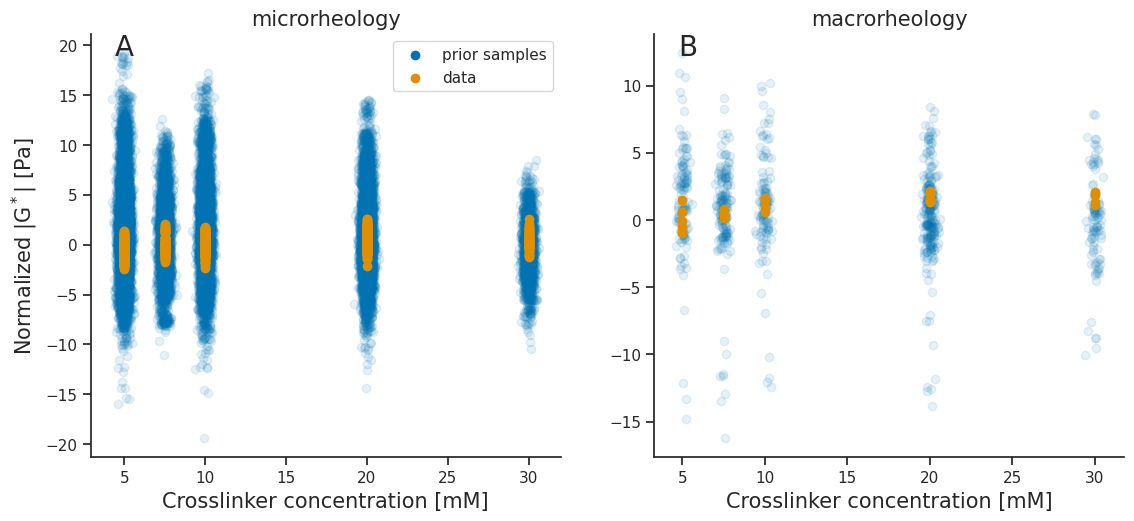

In [7]:
target = model.experimental_pin(likelihood=G,likelihood_macro=G_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)
prior_predictive(model,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,G,G_macro,units,naming,xlabel,mec_type,key)
states,log_probs = run_nuts(model.sample(seed=key),target,bijector,model,key)

In [8]:
#plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states),c_std,c_mean,'switchpoint',mec_type)

Diagnostics

In [9]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states))

StructTuple(
  switchpoint=0,
  slope1=0,
  slope2=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  temperature_mu=0,
  concentration_std=0,
  concentration_z=0,
  temperature_std=0,
  temperature_z=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


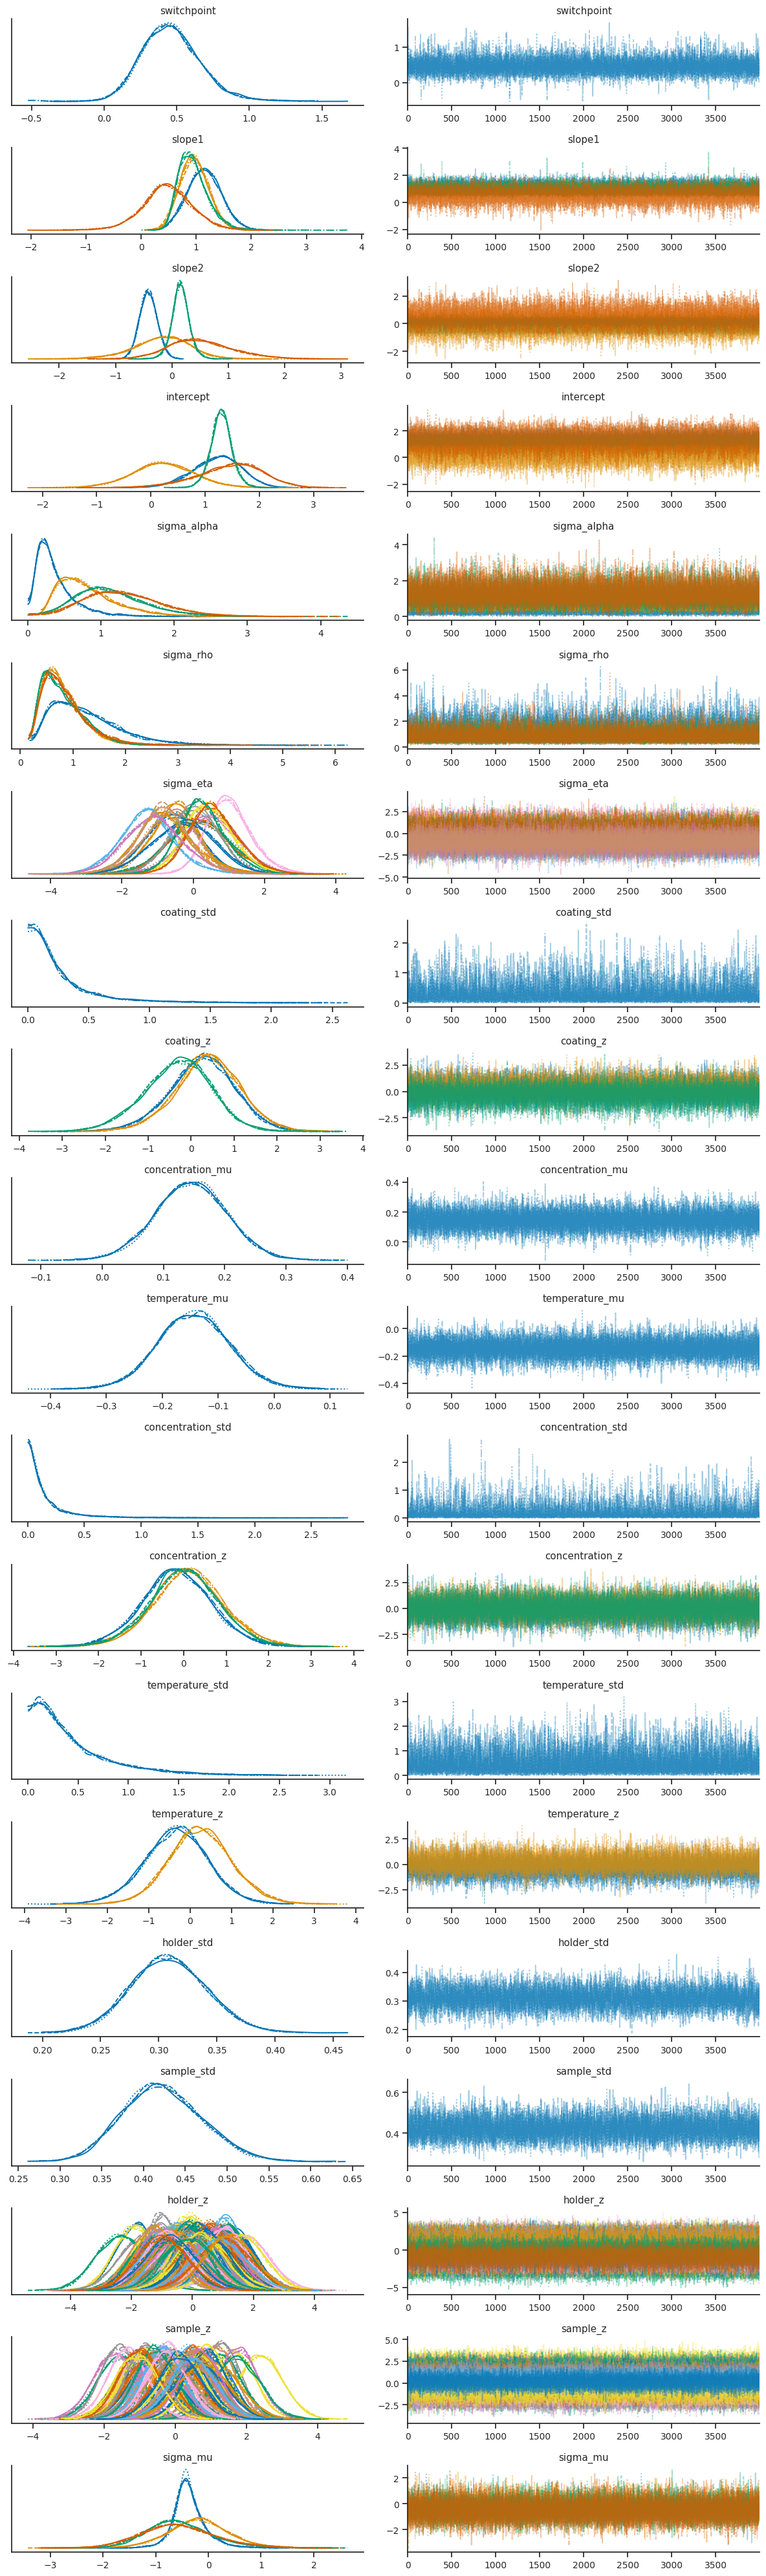

In [10]:
samps = gen_predictive(model,jax.tree_map(lambda x: jnp.squeeze(x),states))
trace = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states),log_probs,samps,radius_orig,coating_orig,temp_orig,concentration_orig,G_names,G_macro_names,G,G_macro,model_type)
ax = az.plot_trace(trace)
ax[0,0].figure.tight_layout()

In [11]:
temp_ef = np.reshape(states.temperature_mu[...,None]+states.temperature_std[...,None]*states.temperature_z,(-1,2))
conc_ef = np.reshape(states.concentration_mu[...,None]+states.concentration_std[...,None]*states.concentration_z,(-1,2))

In [12]:
#_ = az.plot_trace(trace,var_names=['holder_z','holder_std','holder_mean','sample_z','sample_std','sample_mean'])

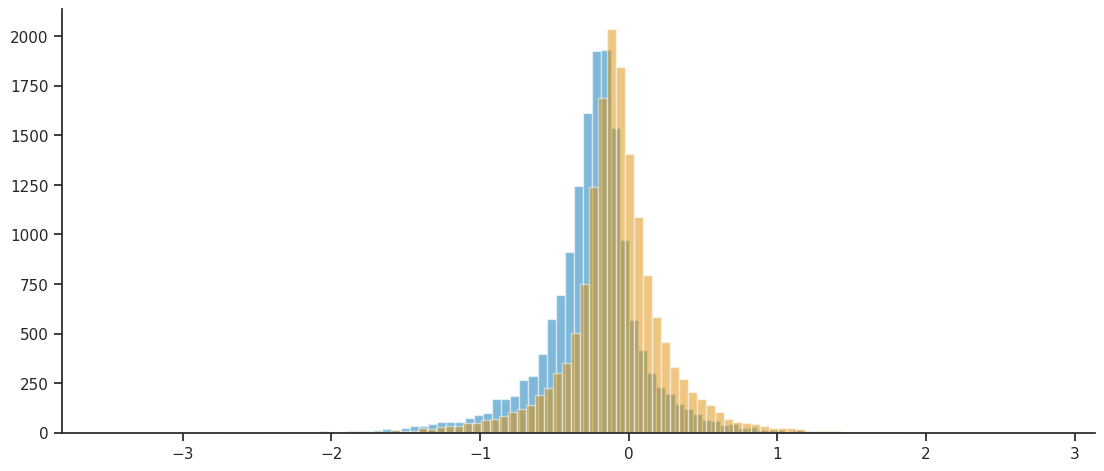

In [13]:
for i in range(2):
    plt.hist(temp_ef[:,i],bins=100,alpha=0.5)

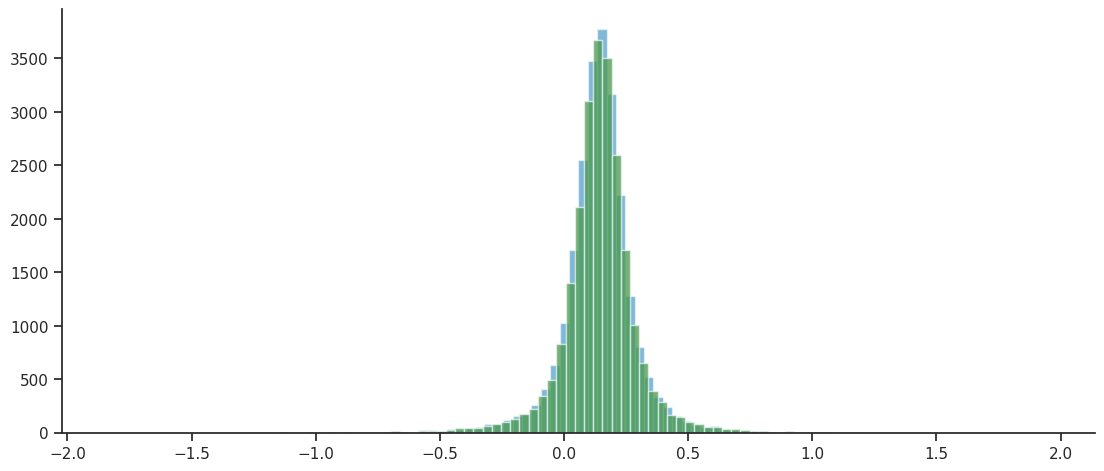

In [14]:
for i in range(3):
    plt.hist(conc_ef[:,i],bins=100,alpha=0.5)

In [ ]:
summary = az.summary(trace,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

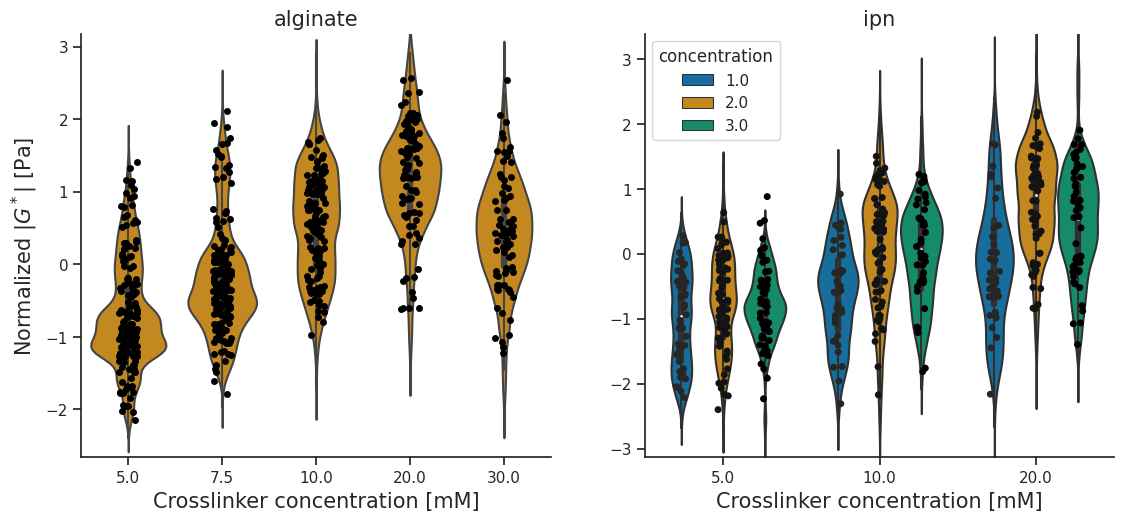

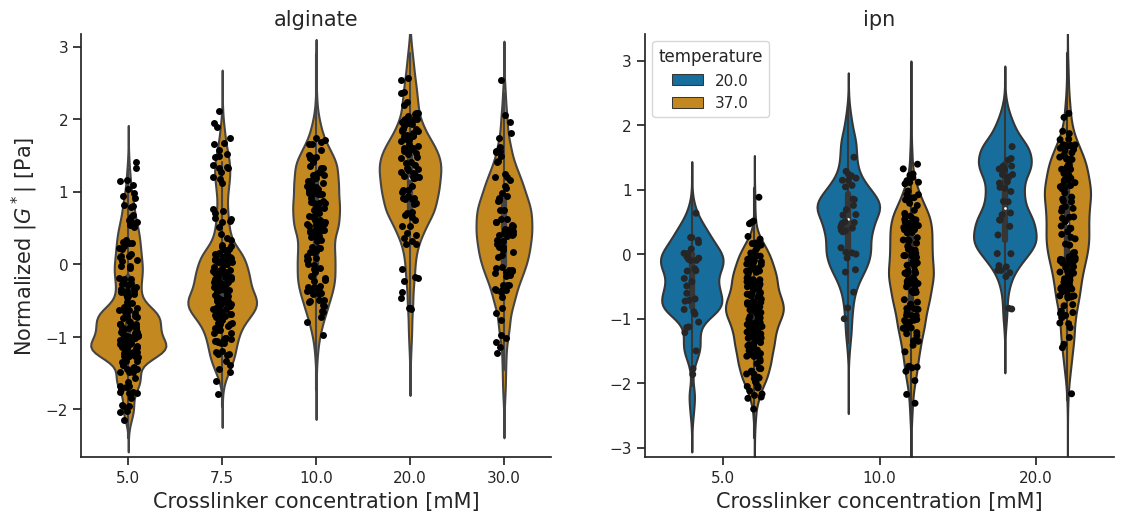

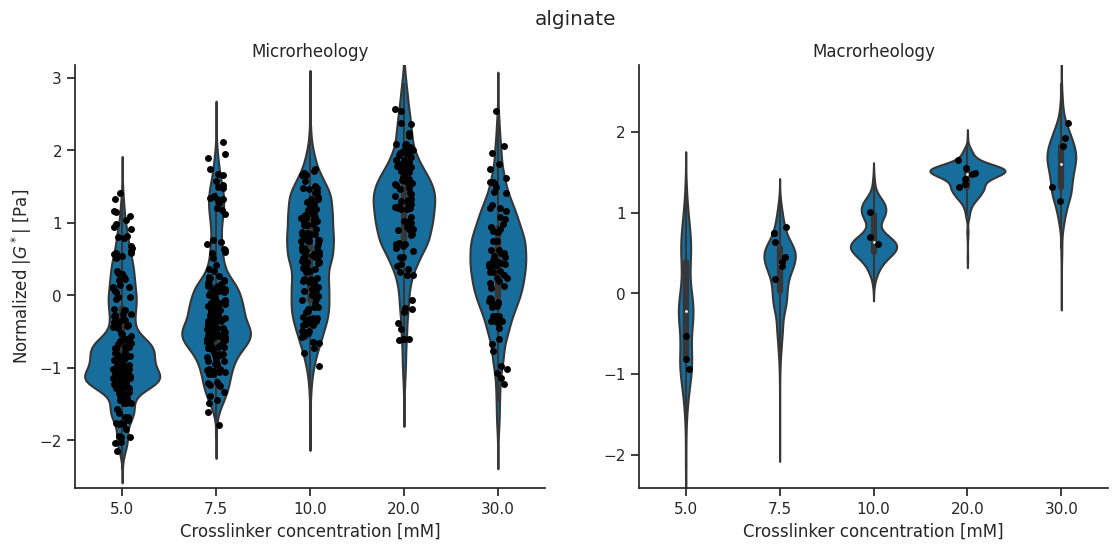

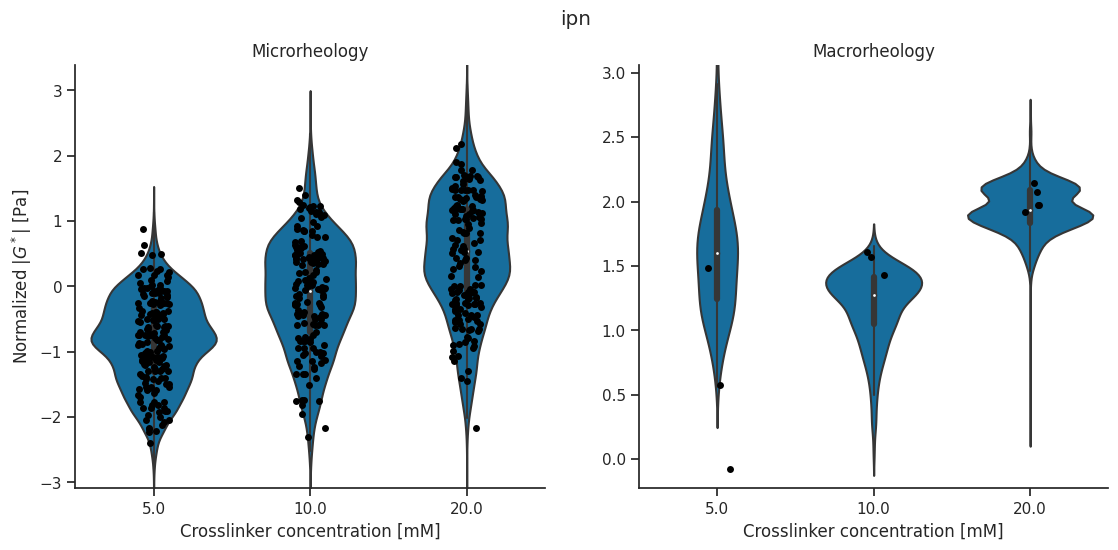

In [15]:
posterior_comparisons(data,macro,samps,states,crosslinker_macro_raw,crosslinker_raw,G,G_macro,xlabel,naming,units,mec_type)

Generate posterior predictive and draw results

In [16]:
N_pred = 100
c_pred = jnp.linspace(crosslinker.min(),crosslinker.max(),N_pred)

m1 = jnp.concatenate([np.zeros(N_alg),np.ones(N_ipn)]).astype(int)
m2 = jnp.concatenate([np.zeros(N_macro_alg),np.ones(N_macro_ipn)]).astype(int)+2

m1_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),np.ones(N_ipn),np.ones(N_pred)]).astype(int)

m2_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),
                       np.ones(N_ipn),np.ones(N_pred),
                       np.zeros(N_macro_alg),np.zeros(N_pred),
                       np.ones(N_macro_ipn),np.ones(N_pred)]).astype(int)

Compare macro to micro

In [17]:
curve,curve_datapoints,sigma,N_split = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)


Is macro larger than micro?

In [18]:
print(((curve_datapoints[:,2]-curve_datapoints[:,0])>0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)
print(((curve_datapoints[:,3]-curve_datapoints[:,1])>0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)

92.56372
99.91754


Is macro larger than micro (at different crosslinker values)

In [19]:
def micromacro_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff>0.1).sum(axis=0)/diff.shape[0]*100)
micromacro_diff(curve_datapoints,0,2,'alginate')
micromacro_diff(curve_datapoints,1,3,'ipn')

alginate [90.36732  90.17991  87.03149  95.33358  99.906296]
ipn [ 99.98126   99.98126   99.962524 100.        99.66267 ]


Blue is alginate, orange is IPN. Upper image is microrheometer, bottom is macrorheometer

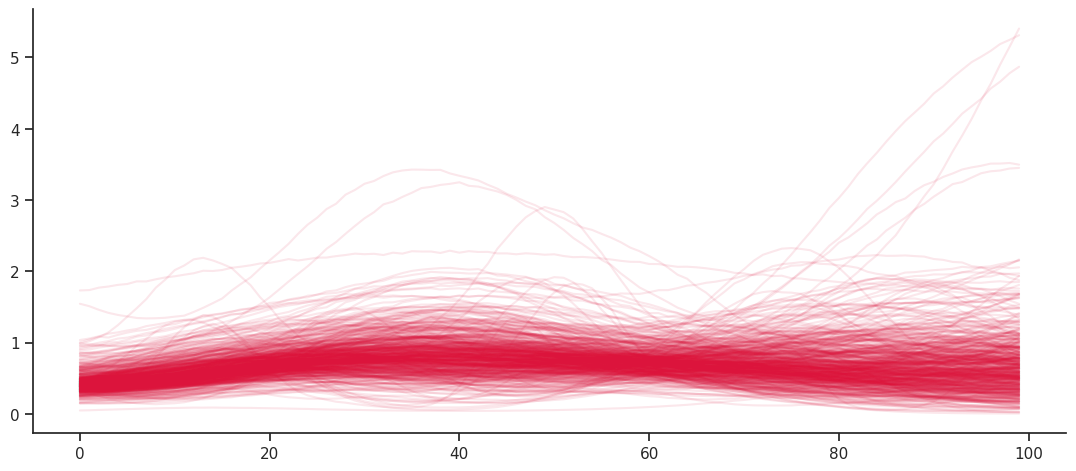

In [20]:
_ = plt.plot(np.reshape(sigma[:,:,(N_ipn+N_alg+N_pred):(N_ipn+N_alg+2*N_pred)],(-1,100))[::10].T,color='crimson',alpha=0.1)

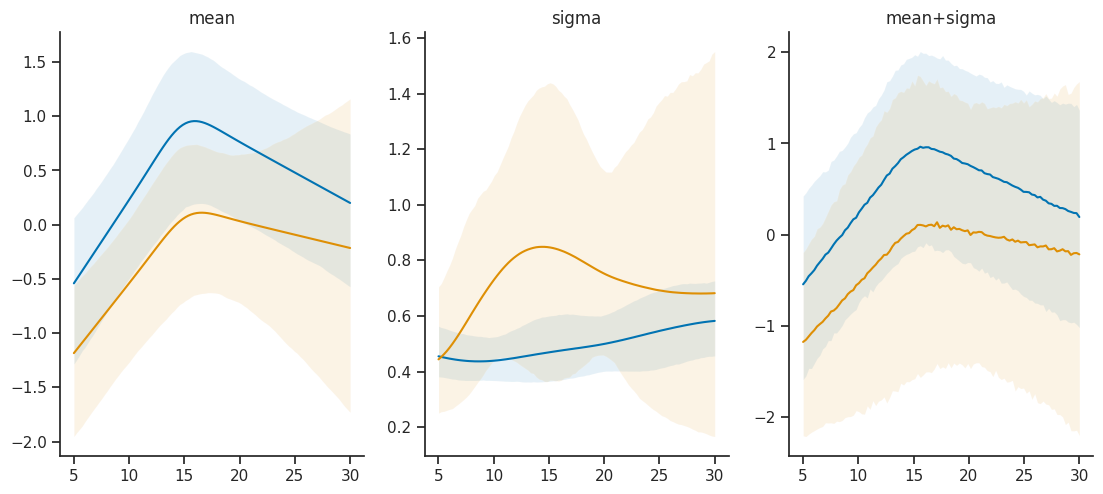

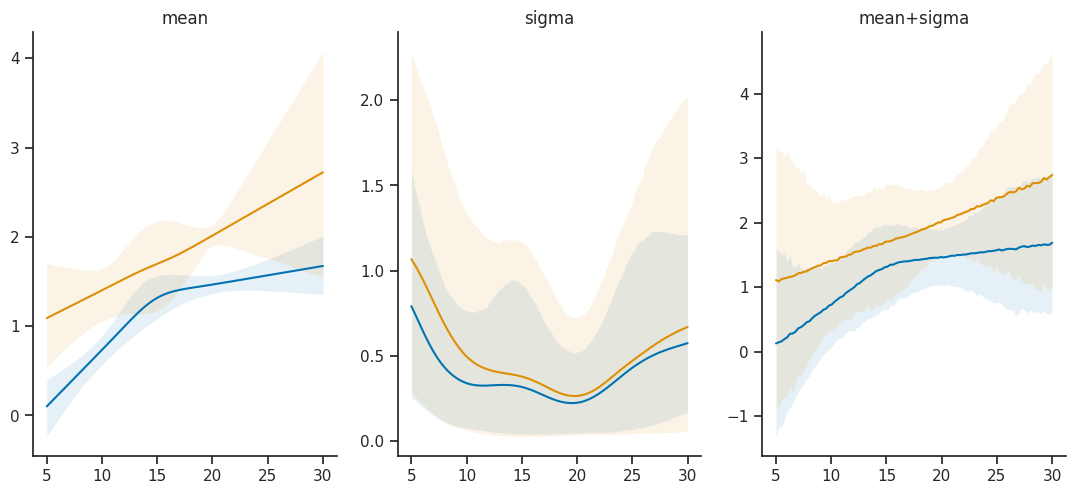

In [21]:
plot_mean(c_pred,c_std,c_mean,curve,sigma,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

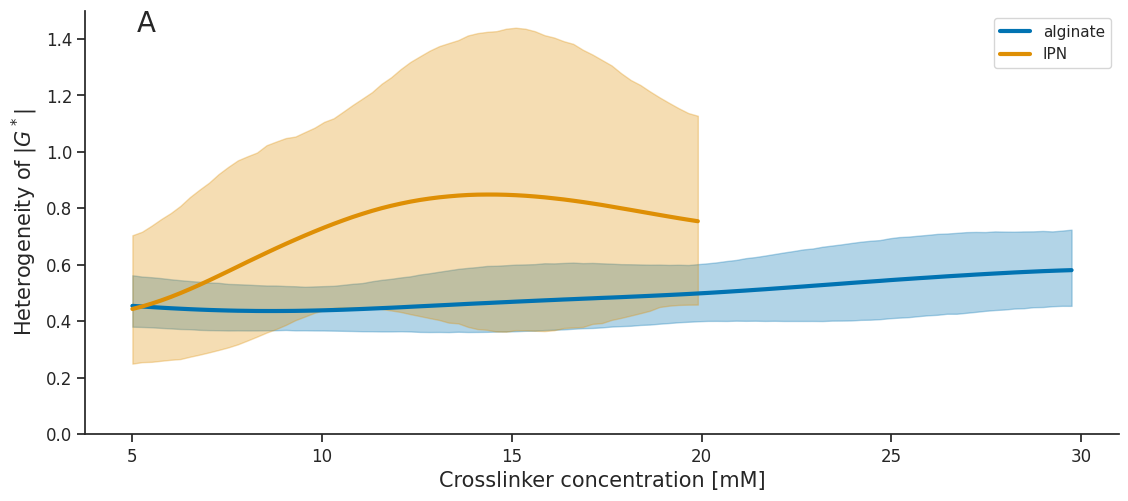

In [22]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma,c_std,c_mean,naming,units,xlabel,mec_type)

Slope being positive

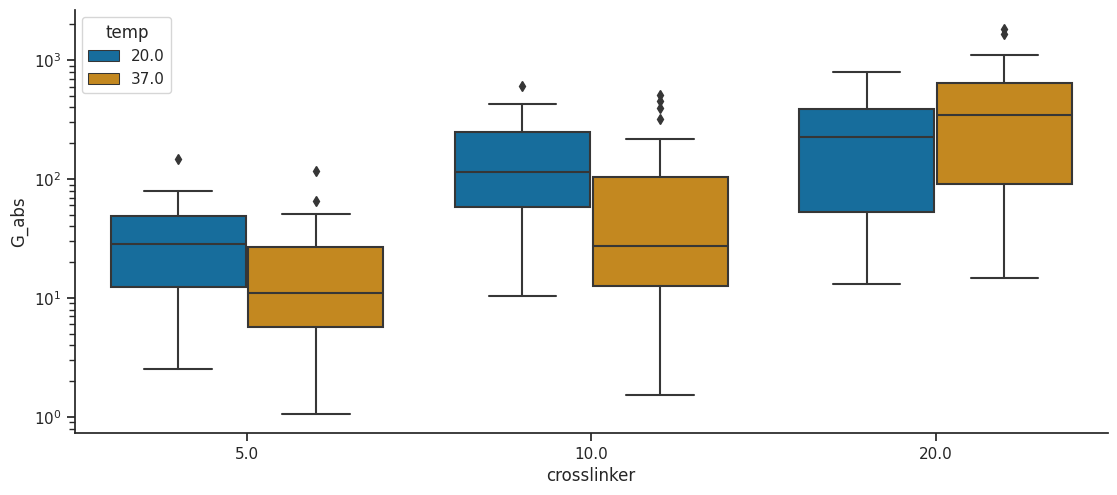

In [23]:
sns.boxplot(data=data[np.logical_and(data['concentration']==2.0,data['type']=='ipn')],x='crosslinker',y='G_abs',hue='temp')
plt.yscale('log')

In [24]:
from functools import partial
from models import rbf
import jax.nn as jnn
sub_sample = 1
N_samples = states.sigma_rho[::sub_sample].shape[0] 
num_c = states.sigma_alpha.shape[1]
K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(einops.rearrange(jax.vmap(partial(rbf,cross_unique_alg[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c),
        einops.rearrange(jax.vmap(partial(rbf,cross_unique_ipn[...,None]))(
                einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_micro)[None,None,...]*(1e-5)


L_K_sigma = jnp.linalg.cholesky(K_sigma)
sigma_data = einops.rearrange(jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,states.sigma_eta[::sub_sample,:,:N_micro])+states.sigma_mu[::sub_sample,:,m1]),
                        'a b c -> (a b) c')
sigma_data_ = einops.rearrange((jnp.einsum('nmij,nmj->nmi',L_K_sigma,states.sigma_eta[::sub_sample,:,:N_micro])+states.sigma_mu[::sub_sample,:,m1]),
                        'a b c -> (a b) c')[:,-N_ipn:]
                        

In [25]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [26]:
temp_ef = np.reshape(states.temperature_std[...,None]*states.temperature_z,(-1,2))
conc_ef = np.reshape(states.concentration_std[...,None]*states.concentration_z,(-1,3))
rad_ef = np.reshape(states.radius_sigma_std[...,None]*states.radius_sigma_z,(-1,4))

In [27]:
a = pd.DataFrame({np.unique(radius_orig)[i]:rad_ef[:,i] for i in range(rad_ef.shape[-1])}).melt()
a['type'] = 'radius'
b = pd.DataFrame({np.unique(concentration_orig)[i]:rad_ef[:,i] for i in range(conc_ef.shape[-1])}).melt()
b['type'] = 'concentration'
c= pd.DataFrame({np.unique(temp_orig)[i]:rad_ef[:,i] for i in range(temp_ef.shape[-1])}).melt()
c['type'] = 'temperature'
effects = pd.concat([a,b,c])

In [28]:
sigma_mean = sigma_data.mean(axis=0)
m_df = pd.DataFrame(sigma_mean,columns=['heterogeneity'])
m_df['type'] = 'model'
m_df['crosslinker'] = [5,7.5,10.,20.,30,5,10,20]
m_df['material'] = [*['alginate']*N_alg,*['ipn']*N_ipn]

In [29]:
sigma_mean

Array([0.45504254, 0.43844023, 0.4384534 , 0.49800766, 0.5813027 ,
       0.44780904, 0.73467666, 0.7584002 ], dtype=float32)

In [30]:
m_df

heterogeneity   type  crosslinker  material
0       0.455043  model          5.0  alginate
1       0.438440  model          7.5  alginate
2       0.438453  model         10.0  alginate
3       0.498008  model         20.0  alginate
4       0.581303  model         30.0  alginate
5       0.447809  model          5.0       ipn
6       0.734677  model         10.0       ipn
7       0.758400  model         20.0       ipn

In [31]:
data['G_abs_norm'] = (np.log(data['G_abs'])-g_mean)/g_std
dat = data.groupby(['type','crosslinker']).std()[['G_abs_norm']].reset_index()
dat.columns = ['material','crosslinker','heterogeneity']
dat['type'] = 'data'
dat

/tmp/ipykernel_23497/321672133.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat = data.groupby(['type','crosslinker']).std()[['G_abs_norm']].reset_index()


material  crosslinker  heterogeneity  type
0  alginate          5.0       0.802327  data
1  alginate          7.5       0.780977  data
2  alginate         10.0       0.661833  data
3  alginate         20.0       0.771510  data
4  alginate         30.0       0.809058  data
5       ipn          5.0       0.688181  data
6       ipn         10.0       0.840472  data
7       ipn         20.0       0.915738  data

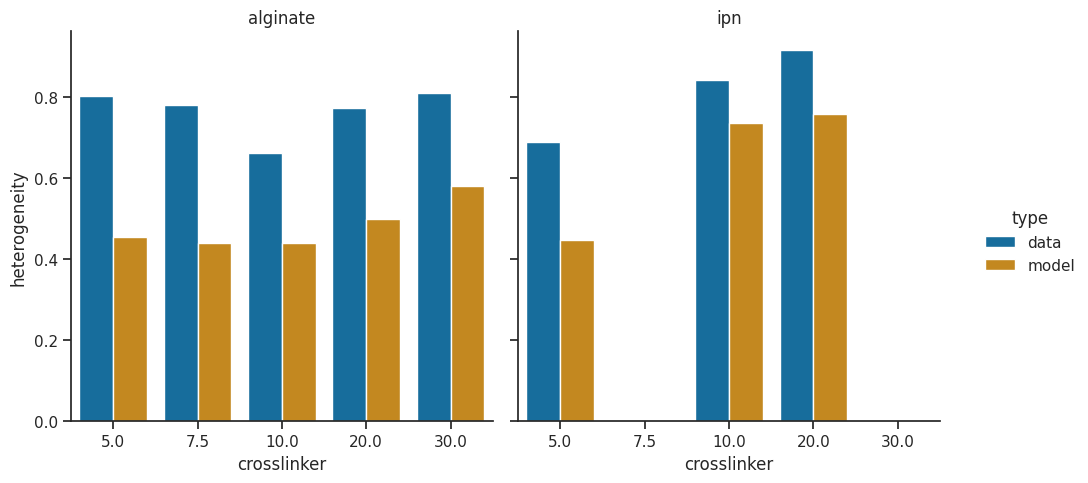

In [32]:
comb = pd.concat([dat,m_df])
g = sns.catplot(data=comb,col='material',x='crosslinker',y='heterogeneity',
            hue='type',kind='bar',sharey=True,margin_titles=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

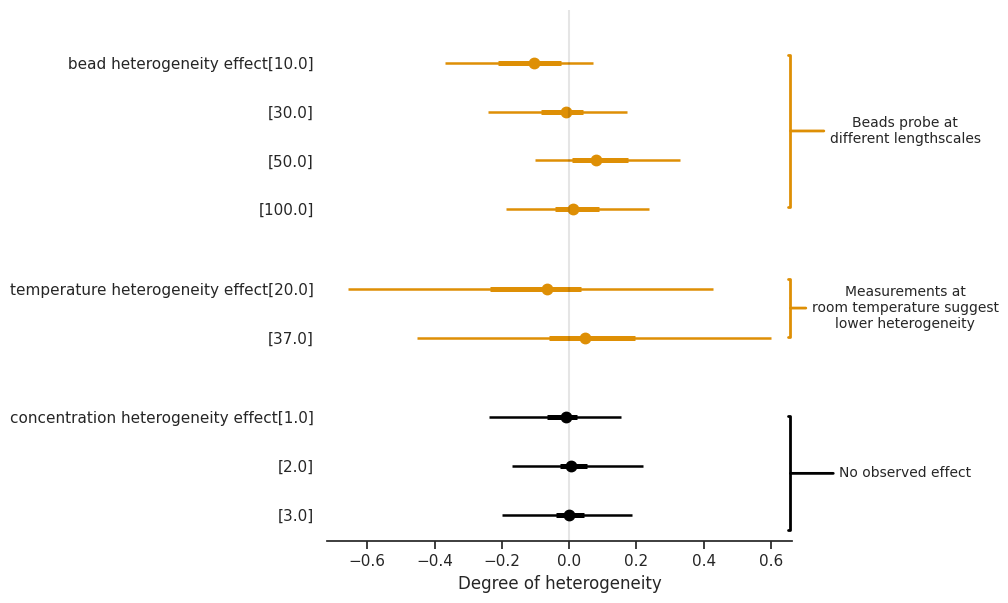

In [125]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "bead effect",
                                         "coating_effect": "coating effect ",
                                         "radius_sigma_effect": " bead heterogeneity effect",
                                         "temperature_sigma_effect": "temperature heterogeneity effect",
                                         "concentration_sigma_effect": "concentration heterogeneity effect",
                                         "temperature_mu":"temperature effect",
                                         "concentration_mu":"concentration effect",
                                         "holder_std": "holder effect",
                                         "sample_std":"sample effect"})

ax = az.plot_forest(trace,
                    var_names=['radius_sigma_effect','temperature_sigma_effect',
                               'concentration_sigma_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10)
col = sns.color_palette('colorblind')[1]
if True:
    for i in ax[0].get_children()[2::3][:-3]:
        i.set_markerfacecolor('black')
    for i in ax[0].get_children()[2::3][3:-3]:
        i.set_markerfacecolor(col)
    for i in range(9,27): 
        ax[0].get_children()[i].set_color(col)


    ax[0].annotate('Beads probe at\ndifferent lengthscales', xy=(0.65, 6.5),  xytext=(1, 6.5),
                arrowprops=dict(color=col, lw=2, arrowstyle='-[,widthB=5.5, lengthB=0.2, angleB=0'),
                ha='center', size=10,verticalalignment='center')


    ax[0].annotate('Measurements at\nroom temperature suggest\nlower heterogeneity', xy=(0.65, 3.5),  xytext=(1, 3.5),
                arrowprops=dict(color=col, lw=2, arrowstyle='-[,widthB=2.1, lengthB=0.2, angleB=0'),
                ha='center', size=10,verticalalignment='center')
    
    ax[0].annotate('No observed effect', xy=(0.65, 0.7),  xytext=(1, 0.7),
                arrowprops=dict(color='black', lw=2, arrowstyle='-[,widthB=4.1, lengthB=0.2, angleB=0'),
                ha='center', size=10,verticalalignment='center')
    
    ax[0].axvline(0,color='black',alpha=0.1)
    ax[0].set_title('')
    ax[0].set_xlabel('Degree of heterogeneity')
#ax[0].axvspan(-0.05,0.05,color='gray',alpha=0.2)

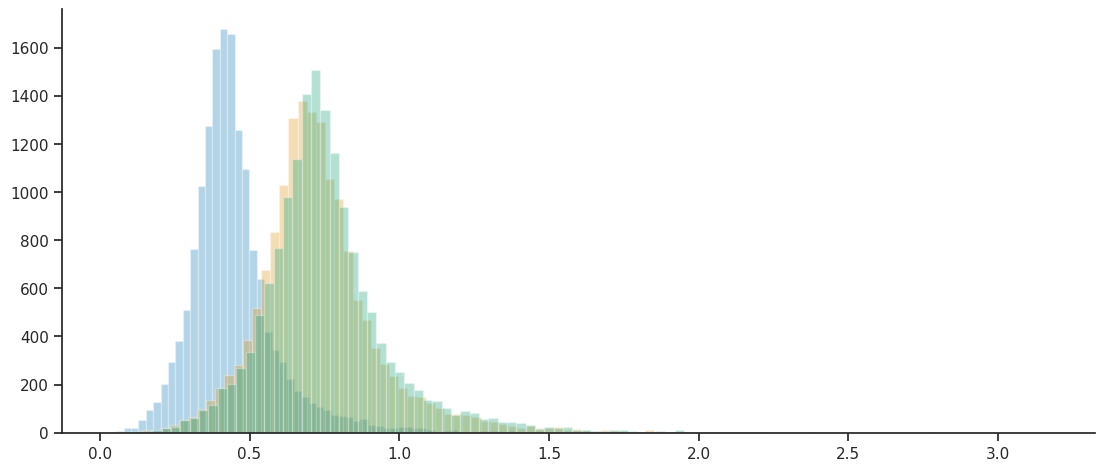

In [120]:
for i in range(3):
    plt.hist(jnn.softplus(sigma_data_[:,i]),bins=100,alpha=0.3)

Text(1.8, 9.5, 'Beads probe at\ndifferent lengthscales')

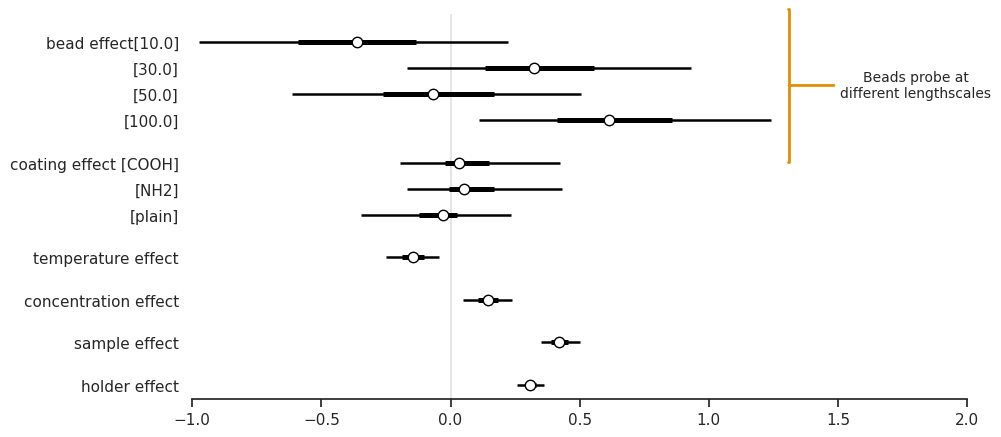

In [111]:
ax = az.plot_forest(trace,
                    var_names=['radius_effect','coating_effect','temperature_mu','concentration_mu',
                               'sample_std','holder_std'],
                    combined=True,labeller=labeller,hdi_prob=0.89,
                    colors='black',linewidth=1.8,
                    markersize=10,figsize=(10,5))
ax[0].axvline(0,color='black',alpha=0.1)
ax[0].set_title('')
ax[0].set_xmargin(0.5)
ax[0].set_xlim(-1.0,2.0)
ax[0].annotate('Beads probe at\ndifferent lengthscales', xy=(1.3, 9.5),  xytext=(1.8, 9.5),
            arrowprops=dict(color=col, lw=2, arrowstyle='-[,widthB=5.5, lengthB=0.1, angleB=0'),
            ha='center', size=10,verticalalignment='center')
#ax[0].axvspan(-0.1,0.1,color='gray',alpha=0.2)

In [337]:
#df = pd.DataFrame((sigma_data.mean(axis=0)*g_std)+g_mean,columns=['y'])
df = pd.DataFrame(jnn.softplus(sigma_data_.mean(axis=0)),columns=['y'])
df['crosslinker'] = [5,10,20]
df['condition'] = 'plain'
df

y  crosslinker condition
0  0.523750            5     plain
1  0.851401           10     plain
2  0.877125           20     plain

In [339]:
#temp_h_effect = jnn.softplus(sigma_data_.mean(axis=0)[None,:]+temp_ef.mean(axis=0)[:,None])*g_std+g_mean
temp_h_effect = jnn.softplus(sigma_data_.mean(axis=0)[None,:]+temp_ef.mean(axis=0)[:,None])
conc_h_effect = jnn.softplus(sigma_data_.mean(axis=0)[None,:]+conc_ef.mean(axis=0)[:,None])
radius_h_effect = jnn.softplus(sigma_data_.mean(axis=0)[None,:]+rad_ef.mean(axis=0)[:,None])
#full_h_effect = jnn.softplus(sigma_data_.mean(axis=0)[None,:]+temp_ef.mean(axis=0)[:,None]+\
#                             conc_ef.mean(axis=0)[:,None])

In [291]:
u_temps = np.unique(temp_orig)

In [292]:
df_ = pd.DataFrame({u_temps[i]:temp_h_effect[i] for i in range(2)})
df_['crosslinker'] =[5,10,20] 
df_ = df_.melt(id_vars=['crosslinker'],value_vars=[*u_temps],var_name='condition',value_name='y')
dc = pd.concat([df,df_])

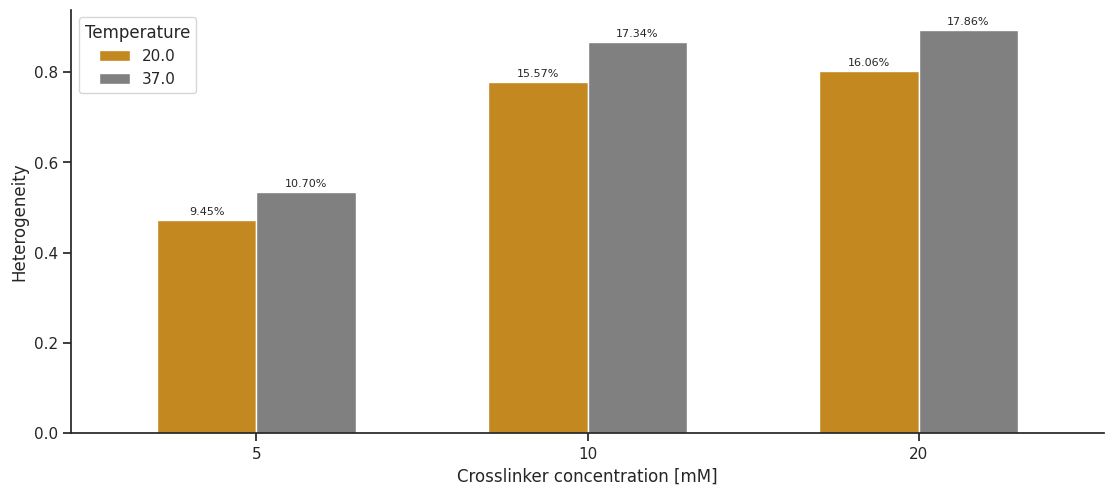

In [293]:
sub = dc[dc['condition']!='plain']

ax = sns.barplot(data=sub,x='crosslinker',y='y',hue='condition',
                 palette=[sns.color_palette('colorblind')[1],'gray']*3,width=0.6)
for p in ax.containers:
    labels = [f'{(v.get_height()/5)*100:0.2f}%' for v in p]
    ax.bar_label(p, labels=labels, label_type='edge', fontsize=8, rotation=0, padding=2)
plt.xlabel(xlabel)
plt.ylabel('Heterogeneity')
plt.legend(title='Temperature')
plt.margins(x=0.1)

In [394]:
jnn.softplus(sigma_data_.mean(axis=0))

Array([0.52374965, 0.8514006 , 0.8771254 ], dtype=float32)

In [294]:
data['G_abs_norm'] = (np.log(data['G_abs'])-g_mean)/g_std

In [319]:
df_ = pd.DataFrame({u_temps[i]:full_h_effect[i] for i in range(2)})
df_['crosslinker'] =[5,10,20] 
df_ = df_.melt(id_vars=['crosslinker'],value_vars=[*u_temps],var_name='condition',value_name='y')
dc = pd.concat([df,df_])
sub = dc[dc['condition']!='plain']
sub['type'] = 'model'

/tmp/ipykernel_216/2814785059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['type'] = 'model'


In [320]:
sub_raw = data[(data['type']=='ipn') & (data['concentration']==2.0)].groupby(['temp','concentration','crosslinker']).std()[['G_abs_norm']].reset_index()
sub_raw.columns = ['condition','concentration','crosslinker','y']
sub_raw = sub_raw[['condition','crosslinker','y']]
sub_raw['type'] = 'data'

/tmp/ipykernel_216/580555476.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sub_raw = data[(data['type']=='ipn') & (data['concentration']==2.0)].groupby(['temp','concentration','crosslinker']).std()[['G_abs_norm']].reset_index()


In [323]:
temp_df = pd.concat([sub,sub_raw])
temp_df

y  crosslinker condition   type
0  0.460845          5.0      20.0  model
1  0.761791         10.0      20.0  model
2  0.785741         20.0      20.0  model
3  0.522207          5.0      37.0  model
4  0.849232         10.0      37.0  model
5  0.874916         20.0      37.0  model
0  0.614439          5.0      20.0   data
1  0.607626         10.0      20.0   data
2  0.708246         20.0      20.0   data
3  0.702491          5.0      37.0   data
4  0.849924         10.0      37.0   data
5  0.827825         20.0      37.0   data

In [325]:
states.radius_sigma_effect

AttributeError: StructTuple has no attribute radius_sigma_effect

<AxesSubplot:xlabel='crosslinker', ylabel='y'>

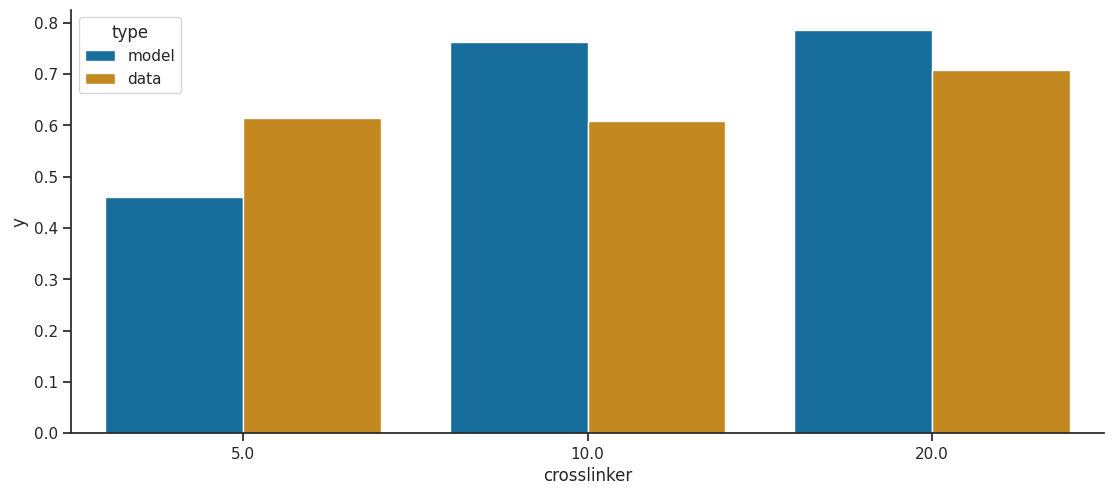

In [324]:
sns.barplot(data=temp_df[temp_df['condition']==20.0],x='crosslinker',y='y',hue='type')

In [29]:
c_flat = einops.rearrange(curve,'i j k l -> (i j) k l')

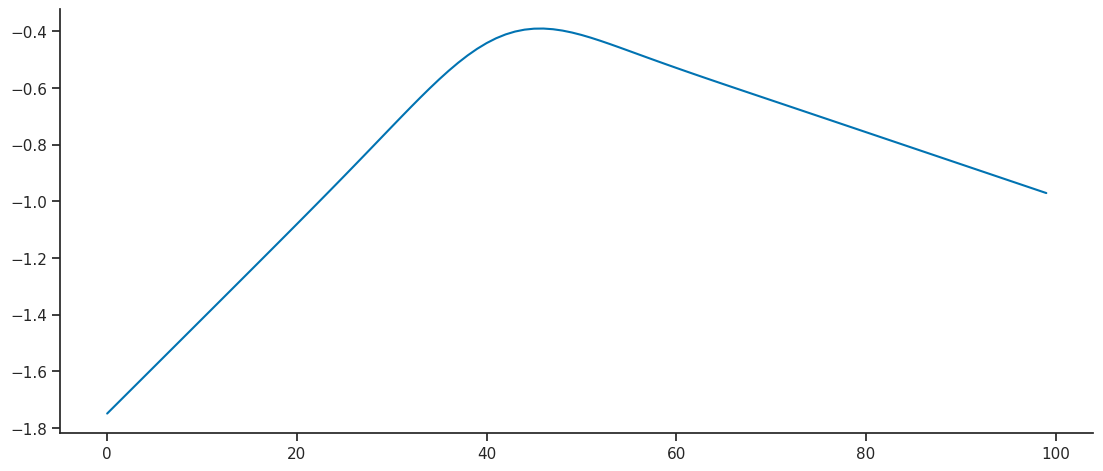

In [32]:
plt.plot(c_flat.mean(axis=0)[1,:])

In [24]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states.slope1),jnp.squeeze(states.slope2)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>0.1)/ee[:,i].shape[0]*100)
    print('---')

100.0
99.96875
99.993744
81.1625
---
0.075
22.293749
64.7125
77.1375
---


Incrase in heterogeneity

In [25]:
increase_in_heterogeneity(states,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 25.72  
alginate 10.0 30.0 71.47  
alginate 20.0 30.0 40.71  
alginate 5.0 10.0 0.73  
alginate 5.0 20.0 22.27  
alginate 5.0 30.0 61.91  
alginate 5.0 7.5 0.01  
alginate 7.5 10.0 1.08  
alginate 7.5 20.0 27.91  
alginate 7.5 30.0 70.24  
ipn 10.0 20.0 14.14  
ipn 5.0 10.0 95.69 * 
ipn 5.0 20.0 96.38 * 


### Some interesting parameters

15.648584


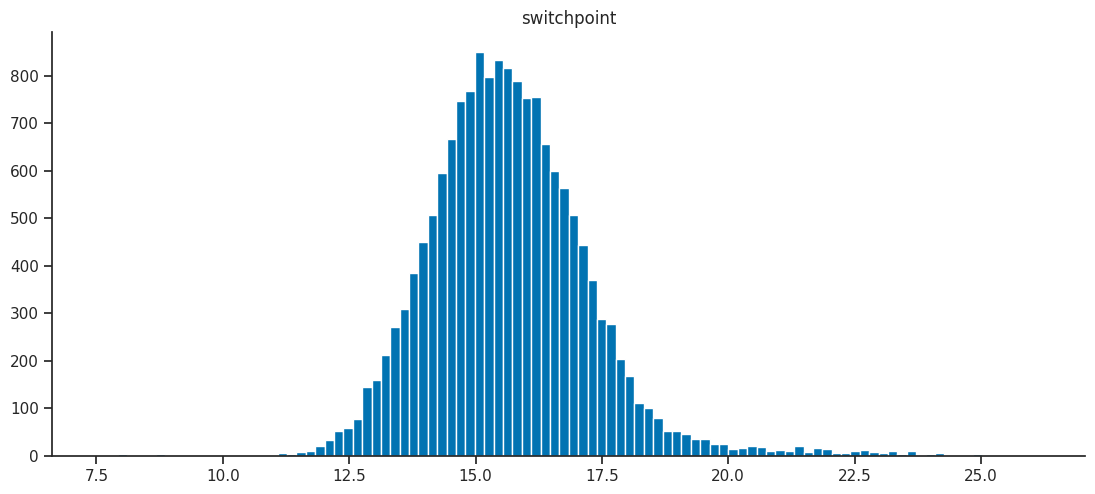

In [24]:
switchpoint = np.array(states.switchpoint.ravel())*c_std+c_mean
_ = plt.hist(switchpoint,bins=100)
plt.title('switchpoint')
print(np.mean(switchpoint))

0.7816875


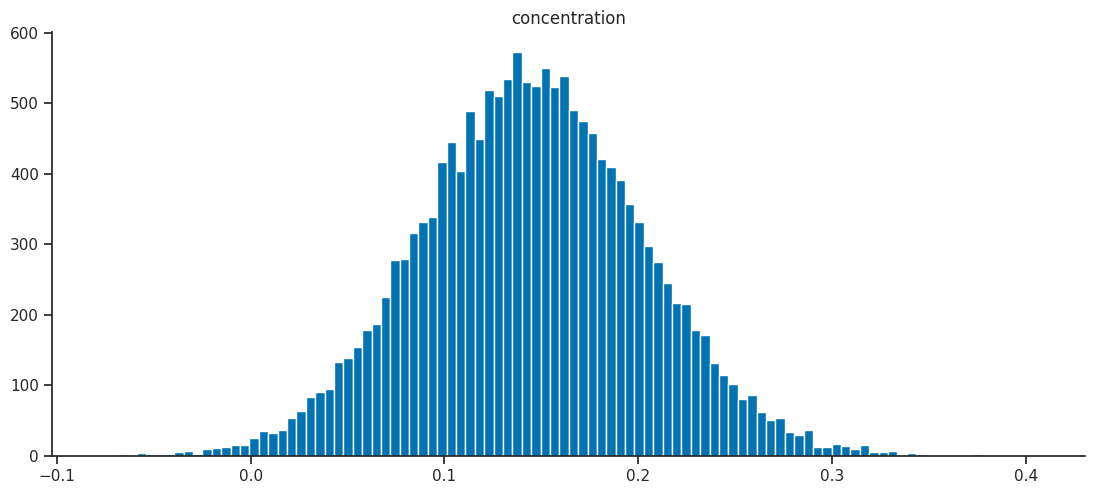

In [25]:
con = np.array(states.concentration_mu.ravel())
_ = plt.hist(con,bins=100)
plt.title('concentration')
print((con>0.1).sum()/con.shape[0])

0.7625625


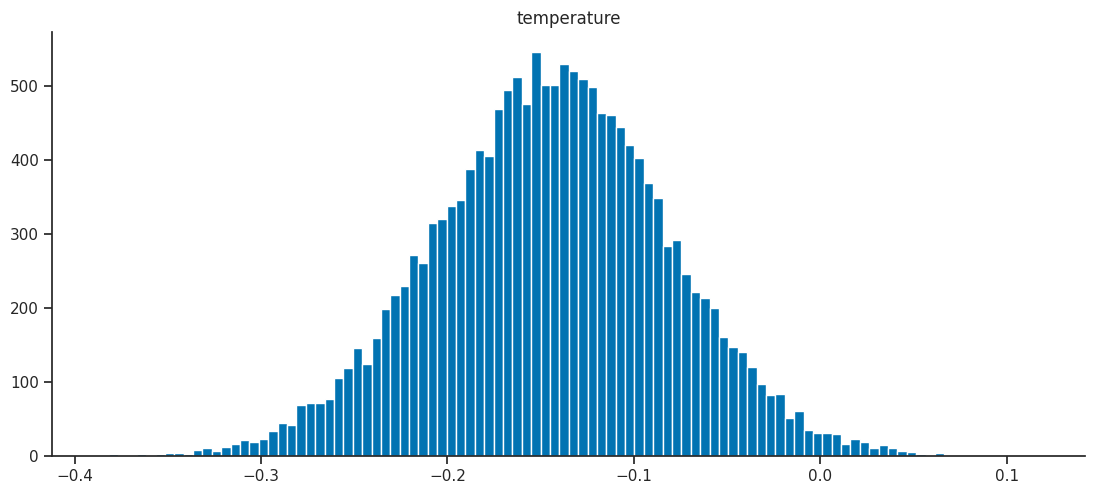

In [26]:
tm = np.array(states.temperature_mu.ravel())
_ = plt.hist(tm,bins=100)
plt.title('temperature')
print((tm<-0.1).sum()/tm.shape[0])

# $\Phi$

In [23]:
model_type = 'linear'
mec_type = 'phi'
naming = '\Phi'
units = 'rad'

In [24]:
model_phi = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,model_type)

target = model_phi.experimental_pin(likelihood=phi,likelihood_macro=phi_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)
prior_predictive(model,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,phi,phi_macro,units,naming,xlabel,mec_type,key)
states_phi,log_probs_phi = run_nuts(model_phi.sample(seed=key),target,bijector,model_phi,key)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


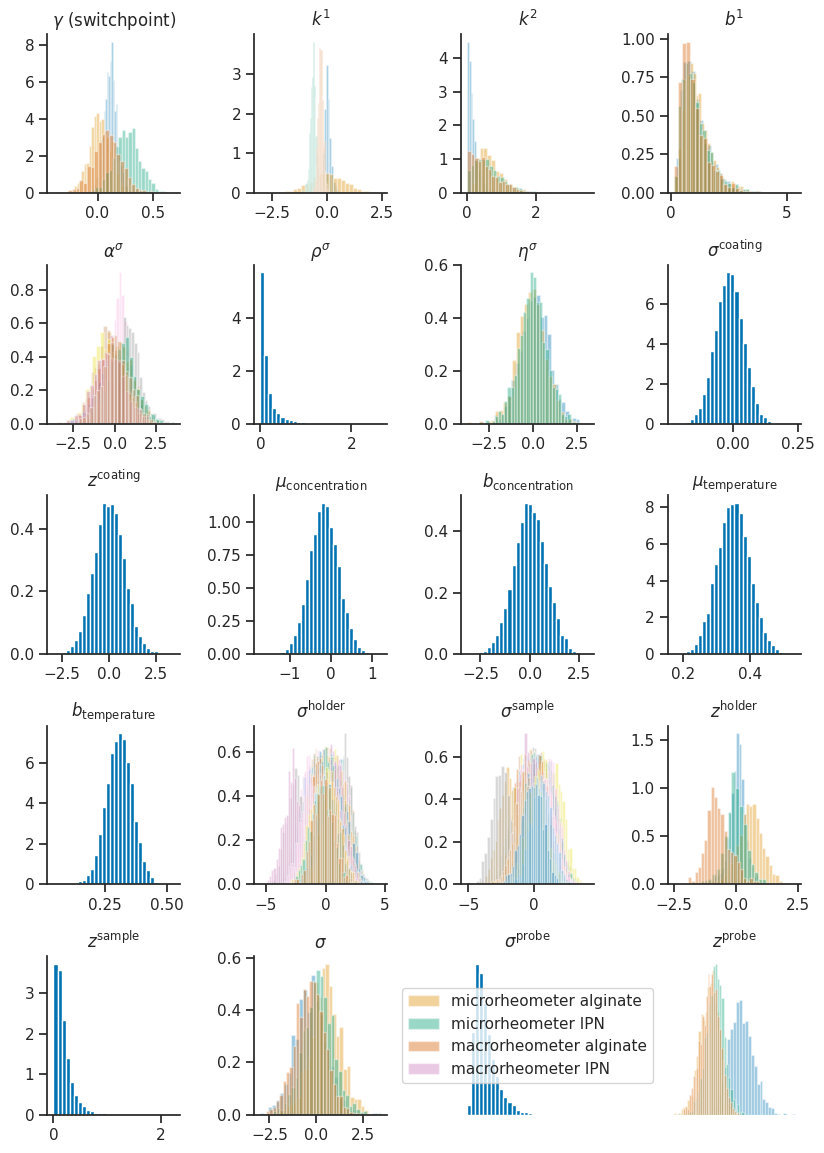

In [ ]:
#plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states_phi),c_std,c_mean,'switchpoint',mec_type)

In [ ]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states_phi))

StructTuple(
  slope1=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  concentration_intercept=0,
  temperature_mu=0,
  temperature_intercept=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


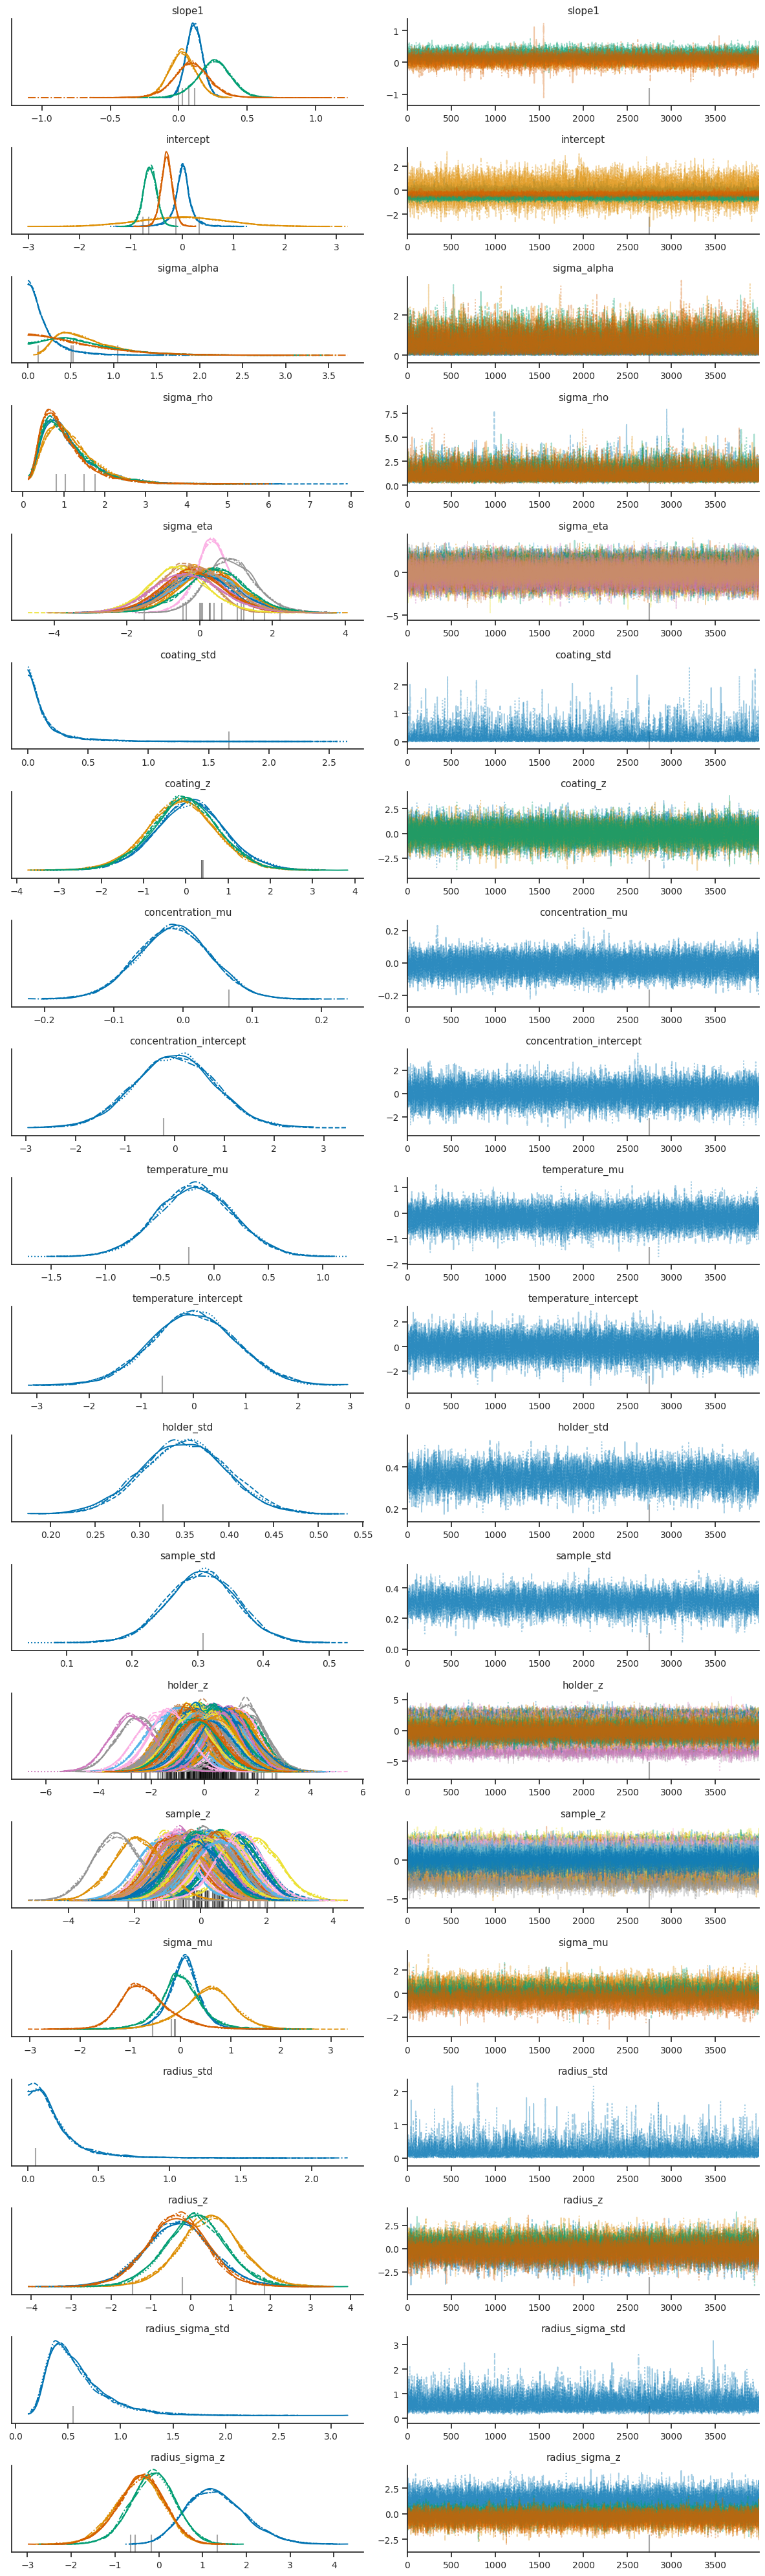

In [ ]:
samps_phi = gen_predictive(model_phi,jax.tree_map(lambda x: jnp.squeeze(x),states_phi))
trace_phi = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),log_probs_phi,samps_phi,radius_orig,coating_orig,G_names,G_macro_names,phi,phi_macro,model_type)
ax = az.plot_trace(trace_phi)
ax[0,0].figure.tight_layout()

In [ ]:
summary_phi = az.summary(trace_phi,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

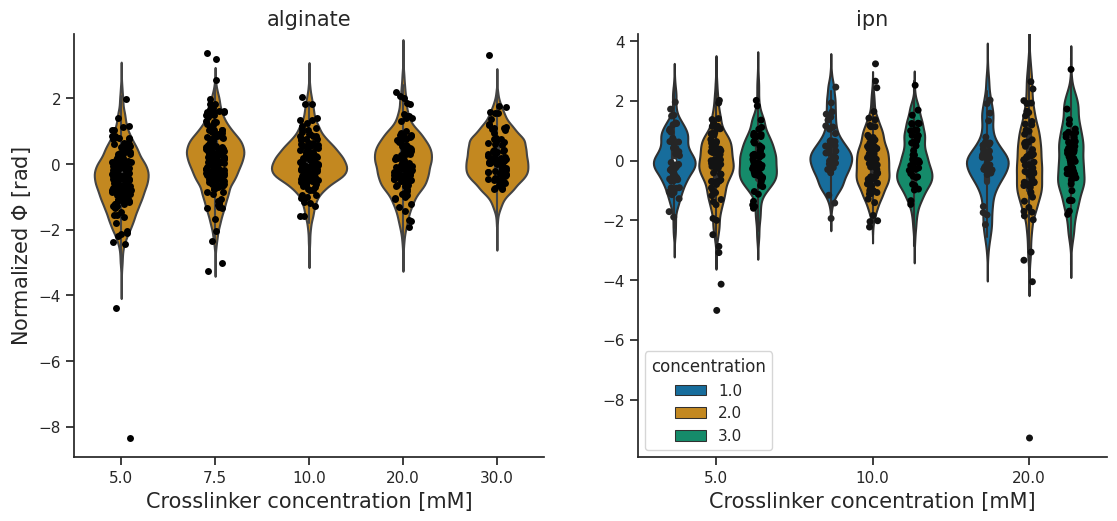

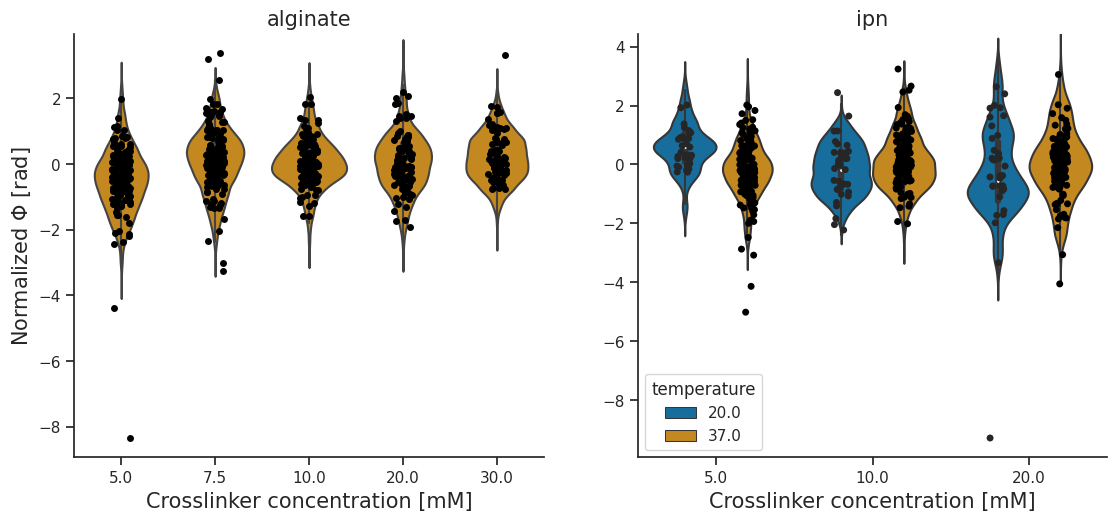

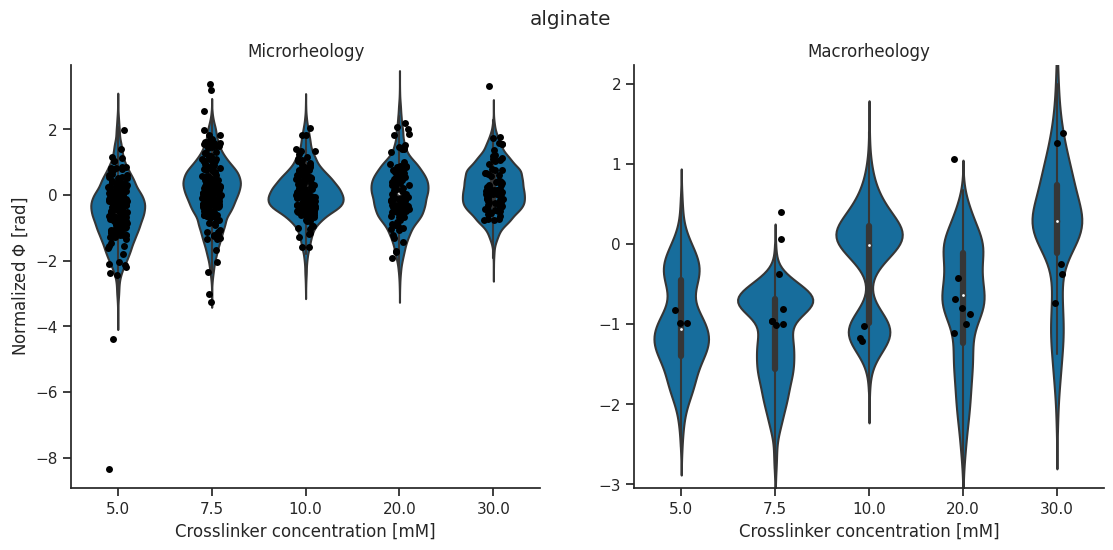

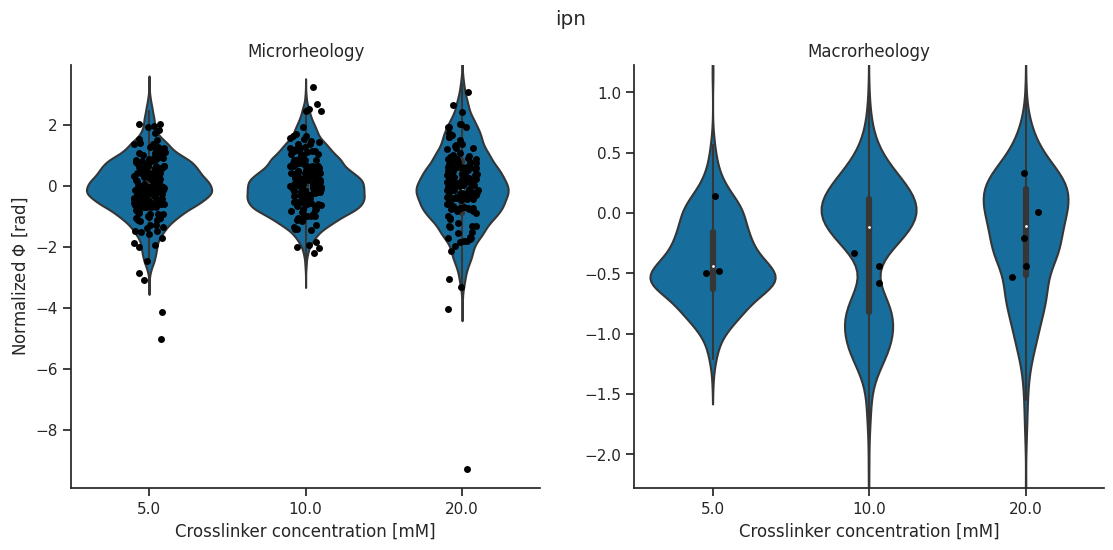

In [ ]:
posterior_comparisons(data,macro,samps_phi,states_phi,crosslinker_macro_raw,crosslinker_raw,phi,phi_macro,xlabel,naming,units,mec_type)

In [ ]:
from functools import partial
from models import rbf
import jax.nn as jnn
def mean_predictions(states,cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,cross_unique,
                     N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type):

    eta_key,sigma_eta_key = jr.split(key,2)
    #N_samples = states.eta.shape[0]
    num_c = states.sigma_alpha.shape[1]
    sub_sample = 3
    N_samples = states.sigma_rho[::sub_sample].shape[0]

    combined_alg = jnp.concatenate([cross_unique_alg,c_pred])
    combined_ipn = jnp.concatenate([cross_unique_ipn,c_pred])

    combined_macro_alg = jnp.concatenate([cross_unique_macro_alg,c_pred])
    combined_macro_ipn = jnp.concatenate([cross_unique_macro_ipn,c_pred])

    N_combined_alg = combined_alg.shape[0]
    N_combined_ipn = combined_ipn.shape[0]

    N_split = N_combined_alg+N_combined_ipn

    N_combined_macro_alg = combined_macro_alg.shape[0]
    N_combined_macro_ipn = combined_macro_ipn.shape[0]

    N_both = N_combined_alg+N_combined_ipn+N_combined_macro_alg+N_combined_macro_ipn

    if model_type=='switchpoint':
        slope1 = states.slope1[::sub_sample,:][...,None]
        slope2 = states.slope2[::sub_sample,:][...,None]
        #switchpoint = states.switchpoint[::sub_sample,:,:][...,None]
        switchpoint = states.switchpoint[::sub_sample,:][...,None]
        intercept = states.intercept[::sub_sample,:][...,None]
        switch = switchpoint[...,None]
        #switch = switchpoint[:,:,[0,0,1,1]]
        #switch = tfb.Shift((20-c_mean)/c_std).forward(switchpoint)[:,:,[0,0,1,1]]
        i2 = (slope2*switch+intercept)-slope1*switch
        slope = slope2+sigmoid(switch-c_pred[None,None,None,...],10)*(slope1-slope2)
        inter = intercept+sigmoid(switch-c_pred[None,None,None,...],10)*(i2-intercept)
        curve = slope*c_pred[None,None,None,...]+inter

        slope_datapoints = slope2+sigmoid(switch-cross_unique[None,None,None,...],10)*(slope1-slope2)
        inter_datapoints = intercept+sigmoid(switch-cross_unique[None,None,None,...],10)*(i2-intercept)
        curve_datapoints = slope_datapoints*cross_unique[None,None,None,...]+inter_datapoints
    else:
        slope1 = states.slope1[::sub_sample,:][...,None]
        intercept = states.intercept[::sub_sample,:][...,None]
        curve = slope1*c_pred[None,None,None,...]+intercept
        curve_datapoints = slope1*cross_unique[None,None,None,...]+intercept


    eta_pred_sigma = jr.normal(sigma_eta_key,(*states.sigma_eta.shape[:2],N_pred))
    eta_both_sigma = jnp.dstack([states.sigma_eta[...,:N_alg],eta_pred_sigma,
                                states.sigma_eta[...,N_alg:(N_alg+N_ipn)],eta_pred_sigma,
                                states.sigma_eta[...,N_micro:(N_micro+N_macro_alg)],eta_pred_sigma,
                                states.sigma_eta[...,(N_micro+N_macro_alg):((N_micro+N_macro_alg+N_macro_ipn))],eta_pred_sigma])


    N_total_sigma = eta_both_sigma.shape[-1]

    K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(
                    # micro
                    einops.rearrange(jax.vmap(partial(rbf,combined_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),

                    einops.rearrange(jax.vmap(partial(rbf,combined_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    # macro
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,2],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,2],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,3],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,3],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_both)[None,None,...]*(1e-4)

    L_K_sigma = jnp.linalg.cholesky(K_sigma)

    sigma = jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,eta_both_sigma[::sub_sample])+states.sigma_mu[::sub_sample,:,m2_])
    curve_datapoints = einops.rearrange(curve_datapoints,'i j k n -> (i j) k n')
    return curve,curve_datapoints,sigma,N_split

is macro smaller than micro?

In [ ]:
curve_phi,curve_datapoints_phi,sigma_phi,_ = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)

print(((curve_datapoints_phi[:,2]-curve_datapoints_phi[:,0])<-0.1).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)
print(((curve_datapoints_phi[:,3]-curve_datapoints_phi[:,1])<-0.1).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)


91.33058
57.85607


In [ ]:
def micromacro_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff<-0.1).sum(axis=0)/diff.shape[0]*100)
micromacro_diff(curve_datapoints_phi,0,2,'alginate')
micromacro_diff(curve_datapoints_phi,1,3,'ipn')

alginate [98.65067  98.65067  98.48201  92.747375 68.12219 ]
ipn [61.43178  60.569717 59.951275 55.92204  51.40555 ]


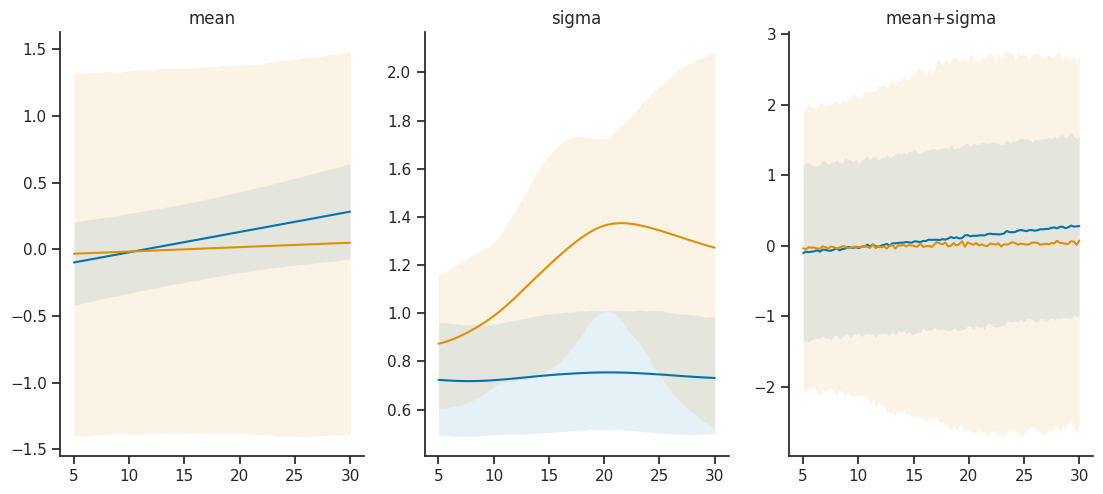

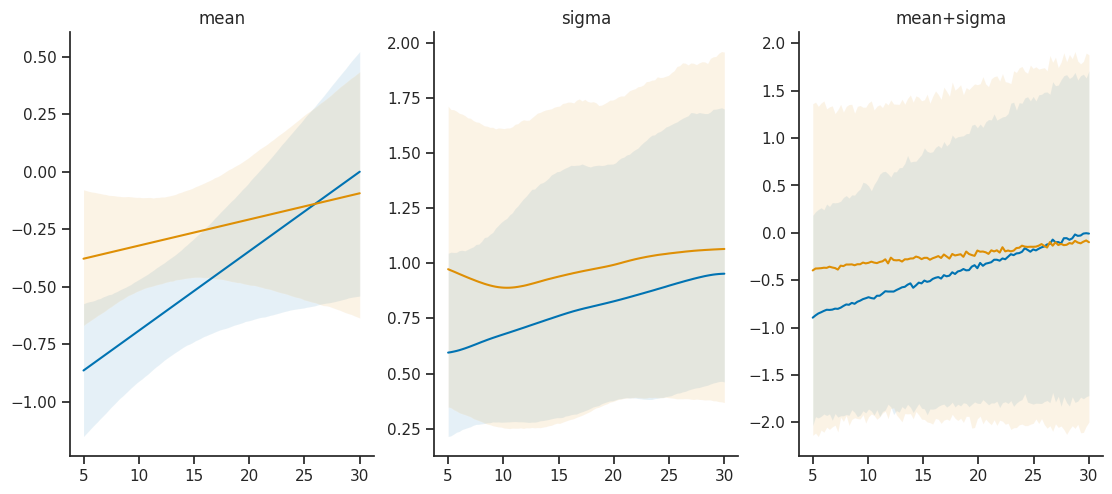

In [ ]:
plot_mean(c_pred,c_std,c_mean,curve_phi,sigma_phi,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

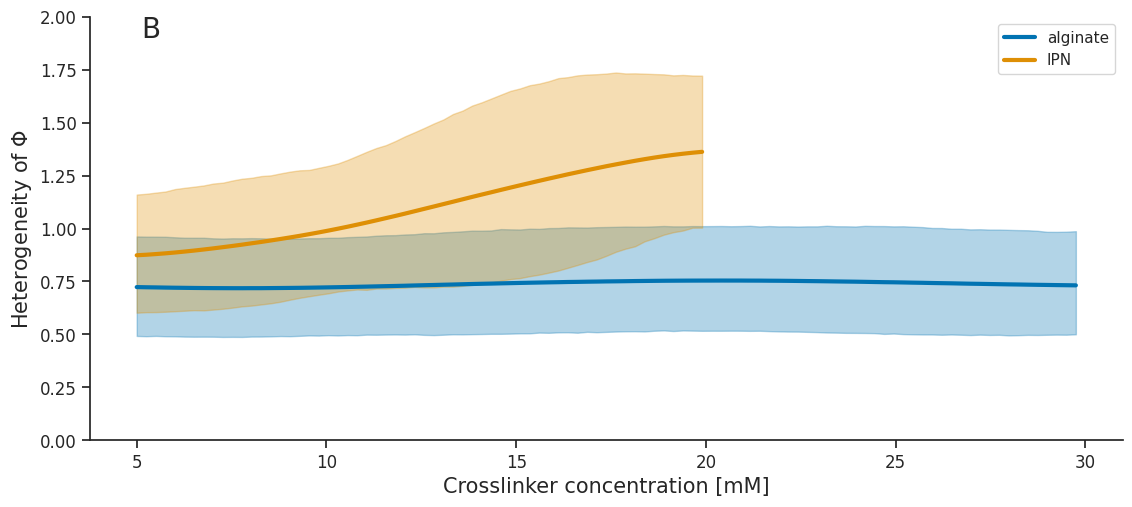

In [ ]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma_phi,c_std,c_mean,naming,units,xlabel,mec_type)

In [ ]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states_phi.slope1)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>0.1)/ee[:,i].shape[0]*100)
    print('---')

58.475
21.95625
90.04375
46.51875
---


In [ ]:
increase_in_heterogeneity(states_phi,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 13.52  
alginate 10.0 30.0 7.4  
alginate 20.0 30.0 1.48  
alginate 5.0 10.0 1.81  
alginate 5.0 20.0 15.76  
alginate 5.0 30.0 9.38  
alginate 5.0 7.5 0.04  
alginate 7.5 10.0 0.94  
alginate 7.5 20.0 16.71  
alginate 7.5 30.0 9.64  
ipn 10.0 20.0 99.91 **** 
ipn 5.0 10.0 58.24  
ipn 5.0 20.0 99.99 **** 


0.015125
0.93475


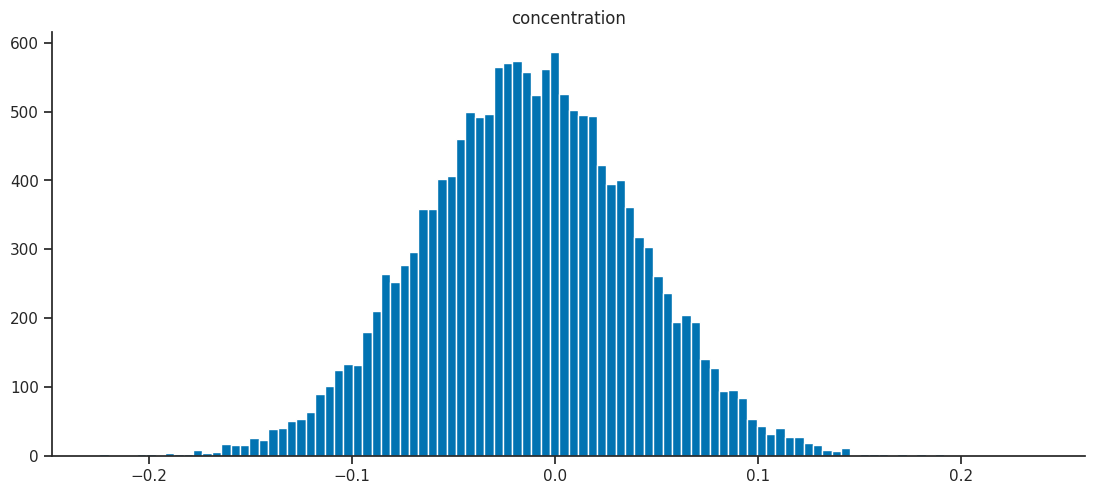

In [ ]:
con = np.array(states_phi.concentration_mu.ravel())
_ = plt.hist(con,bins=100)
plt.title('concentration')
print((con>0.1).sum()/con.shape[0])
print(np.logical_and((con<0.1),con>-0.1).sum()/con.shape[0])

0.582625


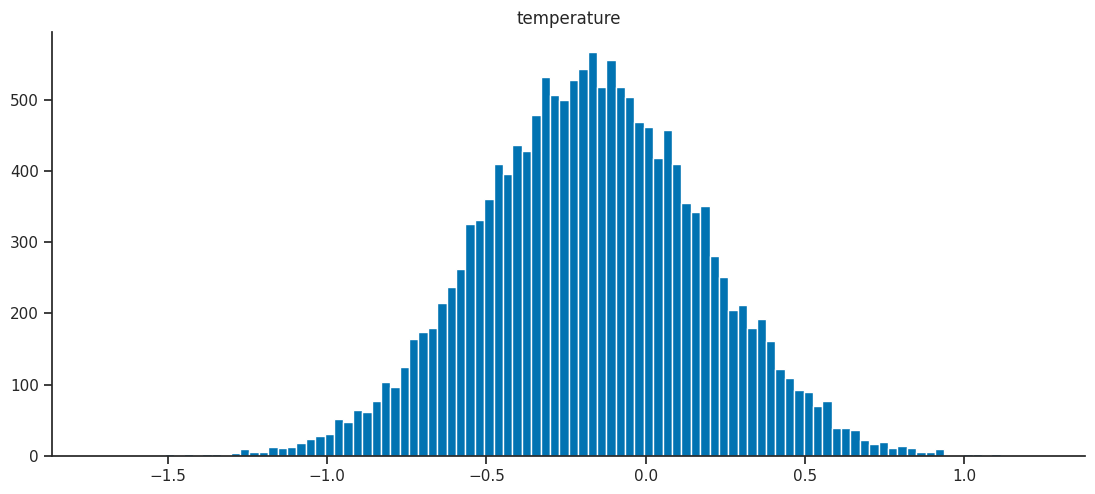

In [ ]:
tm = np.array(states_phi.temperature_mu.ravel())
_ = plt.hist(tm,bins=100)
plt.title('temperature')
print((tm<-0.1).sum()/tm.shape[0])

## Combined plots

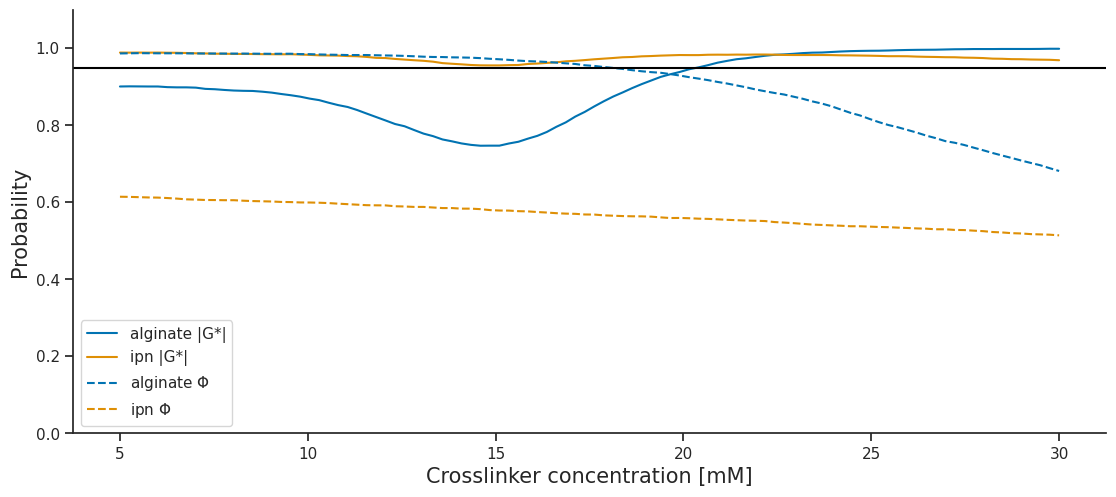

In [ ]:
compare_micromacro(curve,curve_phi,c_pred,c_std,c_mean,xlabel)

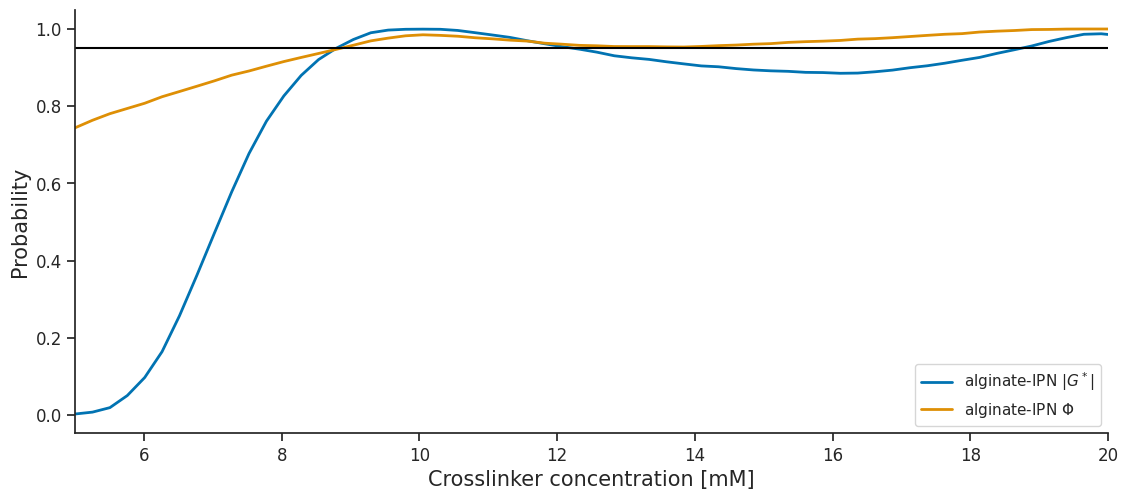

In [ ]:
compare_heterogeneity(sigma,N_alg,N_pred,N_ipn,c_pred,c_std,c_mean,sigma_phi,xlabel)

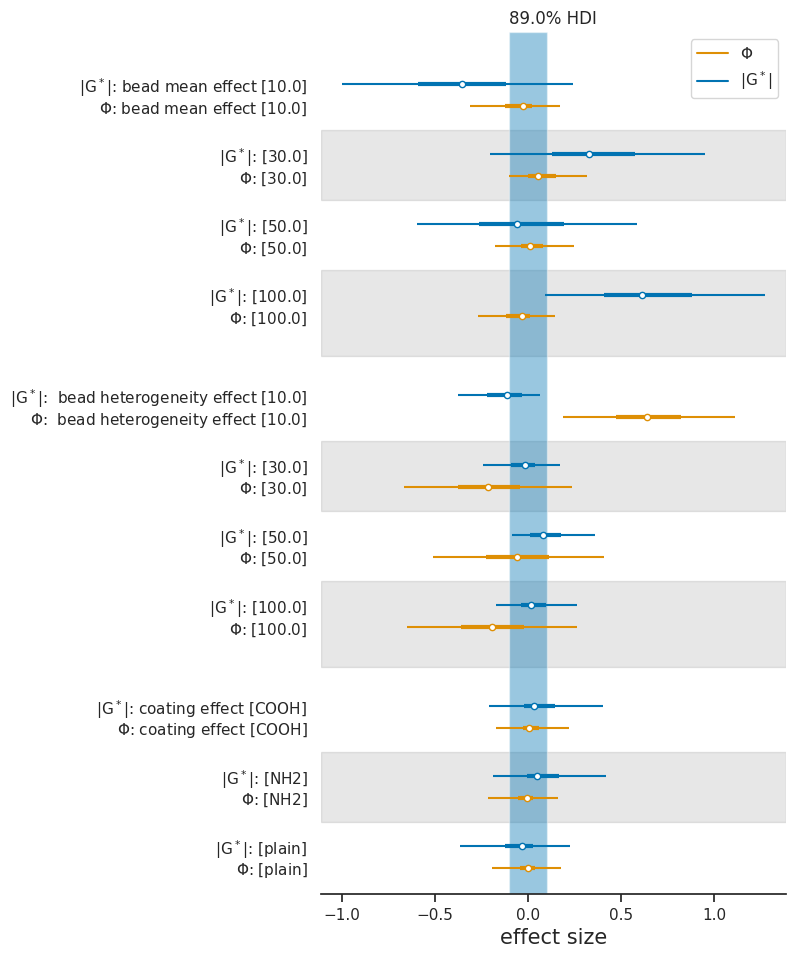

In [ ]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "bead mean effect ",
                                         "coating_effect": "coating effect ",
                                         "radius_sigma_effect": " bead heterogeneity effect "})

ax = az.plot_forest([trace,trace_phi],
                    model_names = [r"|G$^*$|", r"$\Phi$"],
                    var_names=['radius_effect','radius_sigma_effect','coating_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,colors=sns.color_palette('colorblind')[:2])
ax[0].axvspan(-0.1,0.1,alpha=0.4)

ax[0].set_xlabel('effect size',fontsize=15)
fig = ax[0].figure
#ax[0].text(0.05, 0.95, 'B', transform=ax[0].transAxes,fontsize=20)
fig.savefig(f'results/effects_both.png',bbox_inches = 'tight',dpi=300)


In [ ]:
crosslinks = np.array(cross_unique*c_std+c_mean)
g_points=pd.concat({names[i].split(' ')[-1]:pd.DataFrame({crosslinks[j]:\
                    curve_datapoints[:,[0,1]][:,i,j] for j \
                    in range(curve_datapoints[:,[0,1]].shape[-1])}) \
                    for i in range(len(names[:2]))}).reset_index().melt(id_vars=('level_0'),value_vars=crosslinks)

Text(0, 0.5, 'Normalized')

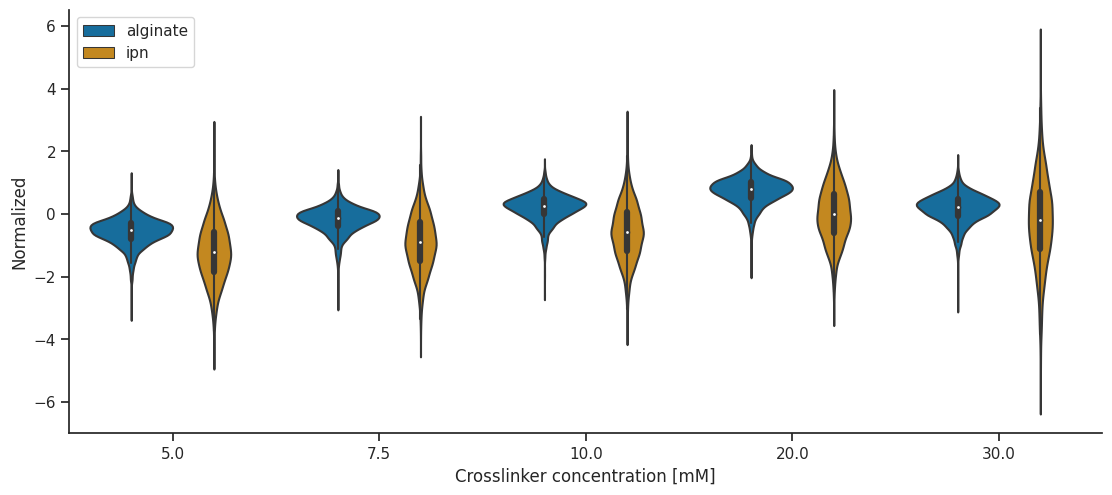

In [ ]:
sns.violinplot(data=g_points,x='variable',y='value',hue='level_0',palette=sns.color_palette('colorblind'))
plt.legend(title='',loc='upper left')
plt.xlabel(xlabel)
plt.ylabel('Normalized')


In [ ]:
ipn_points = np.array(curve_datapoints[:,1,:])

(5336, 5)

In [ ]:
ipn_data = data[data['type']=='ipn'].copy()
#ipn_data['G_abs'] = (np.log(ipn_data['G_abs'])-g_mean)/g_std
#ipn_data['phi_(rad)'] = (np.log(ipn_data['phi_(rad)'])-phi_mean)/phi_std

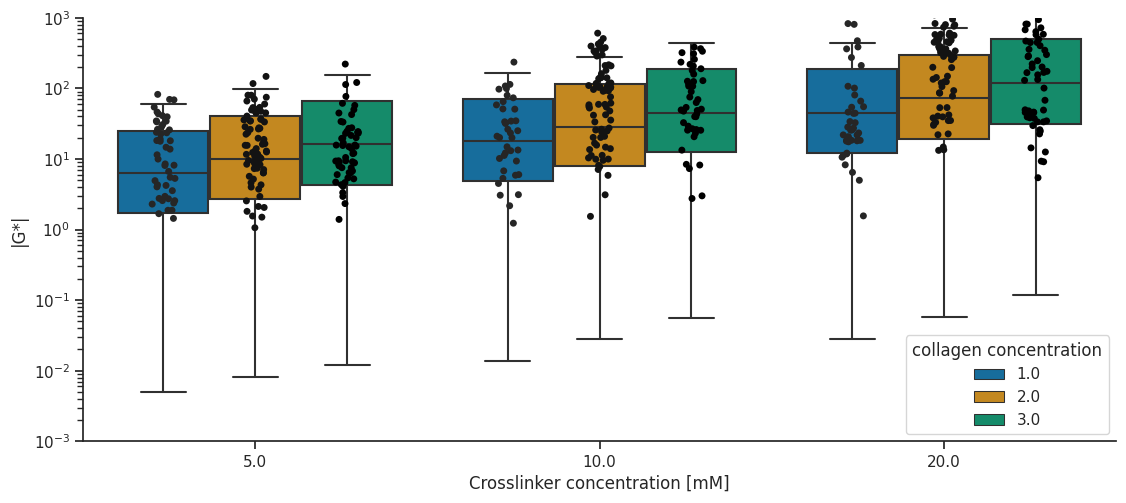

In [ ]:
concentration_values = states.concentration_mu.ravel()[:ipn_points.shape[0]][:,None]*np.unique(concentration)[None,:]+\
    states.concentration_intercept.ravel()[:ipn_points.shape[0]][:,None]

concentration_effects = np.exp((concentration_values[:,None,:]+ipn_points[...,None])*g_std+g_mean)

con_df = pd.concat({f'{i}':pd.DataFrame({crosslinks[j]:\
        concentration_effects[:,j,idx] for j in range(concentration_effects.shape[1])}) \
        for idx,i in enumerate(np.unique(concentration_orig))}).reset_index().melt(id_vars=('level_0'),value_vars=crosslinks)
subset = np.array(cross_unique_ipn*c_std+c_mean)
con_df['variable'] = pd.to_numeric(con_df['variable'])
con_df = con_df[con_df['variable'].isin(np.array(subset))]
fig = plt.figure()
sns.boxplot(data=con_df,x='variable',y='value',hue='level_0',palette=sns.color_palette('colorblind'),fliersize=0)
sns.stripplot(data=ipn_data,x='crosslinker',y='G_abs',hue='concentration',dodge=True,palette='dark:black',legend=False)
plt.legend(title='collagen concentration',loc='lower right')
plt.xlabel(xlabel)
plt.ylabel('|G*|')
plt.yscale('log')
plt.ylim(1e-3,1e3)
fig.savefig(f'results/concentration_effects_G.png',bbox_inches = 'tight',dpi=300)

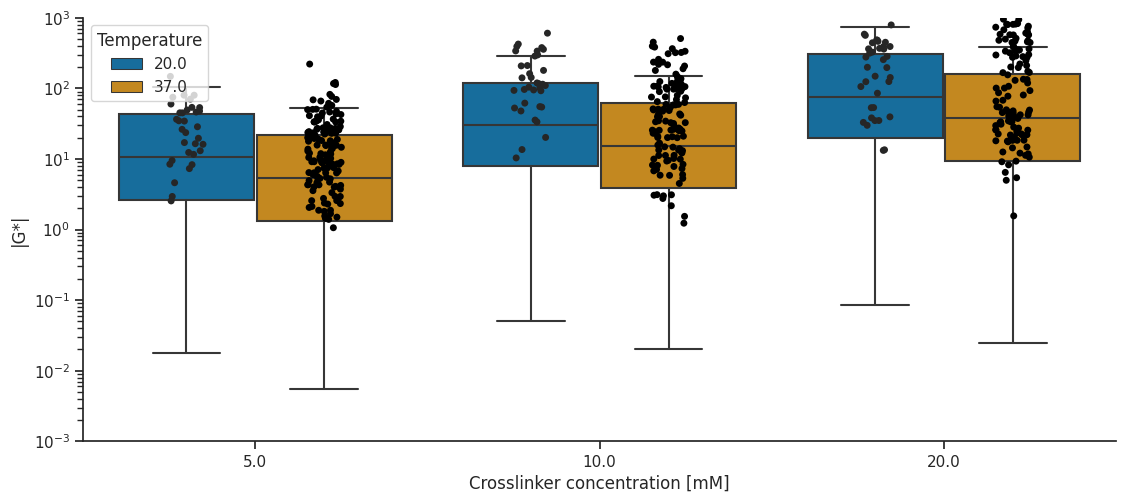

In [ ]:
temperature_values = states.temperature_mu.ravel()[:ipn_points.shape[0]][:,None]*np.unique(temperature)[None,:]+\
    states.temperature_intercept.ravel()[:ipn_points.shape[0]][:,None]

temperature_effects = np.exp((temperature_values[:,None,:]+ipn_points[...,None])*g_std+g_mean)

temp_df = pd.concat({f'{i}':pd.DataFrame({crosslinks[j]:\
        temperature_effects[:,j,idx] for j in range(temperature_effects.shape[1])}) \
        for idx,i in enumerate(np.unique(temp_orig))}).reset_index().melt(id_vars=('level_0'),value_vars=crosslinks)
temp_df['variable'] = pd.to_numeric(temp_df['variable'])
temp_df = temp_df[temp_df['variable'].isin(np.array(subset))]
fig = plt.figure()
sns.boxplot(data=temp_df,x='variable',y='value',hue='level_0',palette=sns.color_palette('colorblind'),fliersize=0)
sns.stripplot(data=ipn_data,x='crosslinker',y='G_abs',hue='temp',dodge=True,palette='dark:black',legend=False)
plt.legend(title='Temperature',loc='upper left')
plt.xlabel(xlabel)
plt.ylabel('|G*|')
plt.yscale('log')
plt.ylim(1e-3,1e3)
fig.savefig(f'results/temperature_effects_G.png',bbox_inches = 'tight',dpi=300)